# OpenDSS-->DiTTo-->OpenDSS Demo

In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Imports

In [64]:
import numpy as np
import pandas as pd
import networkx as nx
import opendssdirect as dss
import sys

from ditto.readers.OpenDSS.read import Reader
from ditto.writers.opendss.write import Writer
from ditto.store import Store

In [65]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
%autoreload 2

### Test feeders paths settings

In [67]:
#Use the feeder variable to use the right test feeder:

def get_master_file(feeder):
    '''
        Get the path to master file of desired feeder
    '''
    if feeder==0:
        return './IEEE_13_nodes_origin/master.dss'
    if feeder==1:
        return './EPRI_J1_origin/master.dss'
    if feeder==2:
        return './IEEE_37_nodes_origin/master.dss'
    if feeder==3:
        return './Demo2_v8/Master.dss'
    if feeder==4:
        return './Demo2_v25_origin/Master.dss'
    if feeder==5:
        return './Demo2_plus_origin/Master.dss'
    
def get_bus_file(feeder):
    '''
        Get the path to buscoord file of desired feeder
    '''
    if feeder==0:
        return './IEEE_13_nodes_origin/IEEE13Node_BusXY.csv'
    if feeder==1:
        return './EPRI_J1_origin/buscoord.dss'
    if feeder==2:
        return './IEEE_37_nodes_origin/IEEE37_BusXY.csv'
    if feeder==3:
        return './Demo2_v8/BusCoord.dss'
    if feeder==4:
        return './Demo2_v25_origin/BusCoord.dss'
    if feeder==5:
        return './Demo2_plus_origin/BusCoord.dss'
    
def get_output_path(feeder):
    '''
        Get the path for the output files (writer)
    '''
    if feeder==0:
        return './IEEE_13_nodes_transformed/'
    if feeder==1:
        return './EPRI_J1_transformed/'
    if feeder==2:
        return './IEEE_37_nodes_transformed/'
    if feeder==3:
        return './Demo2_v8_transformed/'
    if feeder==4:
        return './Demo2_v25_transformed/'
    if feeder==5:
        return './Demo2_plus_transformed/'

def redirect_transformed_master_file(feeder):
    '''
        Redirect the transformed master file
    '''
    if feeder==0:
        dss.dss_lib.DSSPut_Command('redirect ./IEEE_13_nodes_transformed/master.dss')
    if feeder==1:
        dss.dss_lib.DSSPut_Command('redirect ./EPRI_J1_transformed/master.dss')
    if feeder==2:
        dss.dss_lib.DSSPut_Command('redirect ./IEEE_37_nodes_transformed/master.dss')
    if feeder==3:
        dss.dss_lib.DSSPut_Command('redirect ./Demo2_v8_transformed/master.dss')
    if feeder==4:
        dss.dss_lib.DSSPut_Command('redirect ./Demo2_v25_transformed/master.dss')
    if feeder==5:
        dss.dss_lib.DSSPut_Command('redirect ./Demo2_plus_transformed/master.dss')

In [68]:
def static_stats():
    print '------------------------'
    print 'N Capacitors = {}'.format(dss.Capacitors.Count())
    print 'N CapControls = {}'.format(dss.CapControls.Count())
    print 'N Lines = {}'.format(dss.Lines.Count())
    print 'N Loads = {}'.format(dss.Loads.Count())
    print 'N RegControls = {}'.format(dss.RegControls.Count())
    print 'N Transformers = {}'.format(dss.Transformers.Count())
    print 'N Buses = {}'.format(len(dss.Circuit.AllBusNames()))
    print '------------------------'

In [69]:
def compare_voltages(voltages_origin, voltages_transformed):
    '''
        TODO
    '''
    compare=[]
    above=[]
    below=[]
    for i in range(len(voltages_origin)):
        Bus     =voltages_origin.ix[i]['Bus']
        temp = voltages_transformed[voltages_transformed['Bus']==Bus]
        mag_trans= np.max([temp[' Magnitude1'].values[0], 
                           temp[' Magnitude2'].values[0],
                           temp[' Magnitude3'].values[0]])
        mag_orig=np.max([voltages_origin.ix[i][' Magnitude1'],
                         voltages_origin.ix[i][' Magnitude2'],
                         voltages_origin.ix[i][' Magnitude3']])
        if abs(mag_orig-mag_trans)>200:
            above.append(Bus)
        else:
            below.append(Bus)
        compare.append([ mag_trans, mag_orig])
    return np.array(compare)


def compare_voltages_pu(voltages_origin, voltages_transformed):
    '''
        TODO
    '''
    compare=[]
    above=[]
    below=[]
    for i in range(len(voltages_origin)):
        Bus     =voltages_origin.ix[i]['Bus']
        temp = voltages_transformed[voltages_transformed['Bus']==Bus]
        mag_trans= np.max([temp[' pu1'].values[0], 
                           temp[' pu2'].values[0],
                           temp[' pu3'].values[0]])
        mag_orig=np.max([voltages_origin.ix[i][' pu1'],
                         voltages_origin.ix[i][' pu2'],
                         voltages_origin.ix[i][' pu3']])
        if abs(mag_orig-mag_trans)>200:
            above.append(Bus)
        else:
            below.append(Bus)
        compare.append([ mag_trans, mag_orig])
    return np.array(compare)

def compare_angles(voltages_origin, voltages_transformed):
    '''
        TODO
    '''
    compare=[]
    for i in range(len(voltages_origin)):
        Bus     =voltages_origin.ix[i]['Bus']
        temp = voltages_transformed[voltages_transformed['Bus']==Bus]
        mag_trans= np.max([temp[' Angle1'].values[0], 
                           temp[' Angle2'].values[0],
                           temp[' Angle3'].values[0]])
        mag_orig=np.max([voltages_origin.ix[i][' Angle1'],
                         voltages_origin.ix[i][' Angle2'],
                         voltages_origin.ix[i][' Angle3']])
        compare.append([ mag_trans, mag_orig])
    return np.array(compare)


def voltage_profile_plot(ax=None, figsize=(16,10)):
    '''
        Plot the voltage profile of the feeder (in its current state).
        This function can be used to check visually that states of the
        problem are voltage violation free. Just need to call restaure_state
        before calling this function.

        Code from Dheepak Krishnamurthy.
    '''
    buses=set(dss.Circuit.AllBusNames())
    loads=set()
    dss.Loads.First()

    while True:
        for b in dss.CktElement.BusNames():
            loads.add(b.split('.')[0])
        if not dss.Loads.Next()>0:
            break

    buses=(buses-loads)


    if ax is None:
        fig,axs=plt.subplots(1,1,figsize=figsize)
        ax=axs
    ax.yaxis.set_visible(True)
    G,pos=p(1, buses)

    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=5, node_color='red')

    G,pos=p(2, buses)

    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=5, node_color='green')

    G,pos=p(3, buses)

    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=5, node_color='blue')				

    ax.axhline(1.05, color='black', linestyle='--')
    ax.axhline(0.95, color='black', linestyle='--')

    ax.set_ylabel('Voltage (p.u)', fontsize=15)
    ax.set_xlabel('Distance', fontsize=15)

    ax.grid('on')

    return ax


def p(phase, buses):
    '''
        Helper function for voltage_profile_plot.

        Code from Dheepak Krishnamurthy.
    '''
    G=nx.Graph()

    dss.Lines.First()

    while True:
        b1=dss.Lines.Bus1().split('.')[0]
        b2=dss.Lines.Bus2().split('.')[0]

        dss.Circuit.SetActiveBus(b1)
        b1nodes=dss.Bus.Nodes()

        dss.Circuit.SetActiveBus(b2)
        b2nodes=dss.Bus.Nodes()

        if phase in b1nodes and phase in b2nodes and b1 in buses and b2 in buses:
            G.add_edge(b1,b2)

        if not dss.Lines.Next()>0:
            break

    from networkx.drawing.nx_agraph import graphviz_layout

    pos={}

    for n in dss.Circuit.AllBusNames():
        if n in G.nodes():
            dss.Circuit.SetActiveBus(n)
            voltages=[abs(complex(i[0], i[1])) for i in zip(*[iter(dss.Bus.PuVoltage())]*2)]
            i=dss.Bus.Nodes().index(phase)
            pos[n]=(dss.Bus.Distance(), voltages[i])

    return G, pos

In [70]:
def compare_data(voltages_origin, voltages_transformed):
    '''
        TODO
    '''
    _compare_data={}
    
    for i in range(len(voltages_origin)):

        Bus=voltages_origin.ix[i]['Bus']
        
        _compare_data[Bus.lower()]={'distance':None,
                                    'origin':{'phase 1':{},
                                              'phase 2':{},
                                              'phase 3':{}}, 
                                    'transformed':{'phase 1':{},
                                                   'phase 2':{},
                                                   'phase 3':{}}}

        dss.Circuit.SetActiveBus(Bus)
        _compare_data[Bus.lower()]['distance']=dss.Bus.Distance()
        
        temp=voltages_transformed[voltages_transformed['Bus']==Bus]
        
        phase_to_do=[1,2,3]
        for p in range(1,4):
            
            if voltages_origin.ix[i][' Node{}'.format(p)]!=0:
                phase=int(voltages_origin.ix[i][' Node{}'.format(p)])
                magnitude=float(voltages_origin.ix[i][' pu{}'.format(p)])
                angle=float(voltages_origin.ix[i][' Angle{}'.format(p)])
                _compare_data[Bus.lower()]['origin']['phase {}'.format(phase)]['magnitude']=magnitude
                _compare_data[Bus.lower()]['origin']['phase {}'.format(phase)]['angle']=angle
                phase_to_do.remove(phase)
            else:
                _compare_data[Bus.lower()]['origin']['phase {}'.format(phase_to_do[0])]['magnitude']=0
                _compare_data[Bus.lower()]['origin']['phase {}'.format(phase_to_do[0])]['angle']=0
                phase_to_do.remove(phase_to_do[0])

        phase_to_do=[1,2,3]
        for p in range(1,4):
            
            if temp[' Node{}'.format(p)].values[0]!=0:
                phase=int(temp[' Node{}'.format(p)])
                magnitude=float(temp[' pu{}'.format(p)])
                angle=float(temp[' Angle{}'.format(p)])
                _compare_data[Bus.lower()]['transformed']['phase {}'.format(phase)]['magnitude']=magnitude
                _compare_data[Bus.lower()]['transformed']['phase {}'.format(phase)]['angle']=angle
                phase_to_do.remove(phase)
            else:
                _compare_data[Bus.lower()]['transformed']['phase {}'.format(phase_to_do[0])]['magnitude']=0
                _compare_data[Bus.lower()]['transformed']['phase {}'.format(phase_to_do[0])]['angle']=0
                phase_to_do.remove(phase_to_do[0])
    return _compare_data

In [71]:
def plot_differences(diff_mag, diff_ang, dista):
    '''
        TODO
    '''
    fig=plt.figure(figsize=(8,8))

    ax=fig.add_subplot(231)
    mask=diff_mag[0]!=0
    plt.scatter(dista[mask],diff_mag[0][mask],alpha=.2)
    ax.set_ylabel('Voltage magnitude difference', fontsize=12)
    ax.set_title('Phase 1', fontsize=14)

    ax2=fig.add_subplot(232, sharey=ax)
    mask=diff_mag[1]!=0
    plt.scatter(dista[mask],diff_mag[1][mask],alpha=.2)
    ax2.set_title('Phase 2', fontsize=14)

    ax3=fig.add_subplot(233, sharey=ax)
    mask=diff_mag[2]!=0
    plt.scatter(dista[mask],diff_mag[2][mask],alpha=.2)
    ax3.set_title('Phase 3', fontsize=14)

    ax4=fig.add_subplot(234, sharex=ax)
    mask=diff_ang[0]!=0
    plt.scatter(dista[mask],diff_ang[0][mask],alpha=.2)
    ax4.set_ylabel('Voltage Angle difference', fontsize=12)

    ax5=fig.add_subplot(235, sharex=ax2)
    mask=diff_ang[1]!=0
    plt.scatter(dista[mask],diff_ang[1][mask],alpha=.2)
    ax5.set_xlabel('Distance from substation', fontsize=12)

    ax6=fig.add_subplot(236, sharex=ax3)
    mask=diff_ang[2]!=0
    plt.scatter(dista[mask],diff_ang[2][mask],alpha=.2)
    plt.tight_layout()

# --------- IEEE 13 Nodes Feeder ---------

In [10]:
feeder=0

### Reading and parsing 

Create the reader:

In [11]:
m=Store()
reader=Reader()
reader.build_opendssdirect(get_master_file(feeder))
reader.set_dss_file_names({'Nodes':get_bus_file(feeder)})

1

Parse the test feeder:

In [12]:
reader.parse(m, verbose=True)

Parsing the nodes...
Succesful!
Parsing the transformers...
Succesful!
Parsing the loads...
Succesful!
Parsing the lines...


/Users/ngensoll/anaconda2/lib/python2.7/site-packages/OpenDSSDirect.py-0.2.9-py2.7.egg/opendssdirect/utils.py:94: UserWarning: Pandas cannot be installed. Please see documentation for how to install extra dependencies.
  "Pandas cannot be installed. Please see documentation for how to install extra dependencies."
2017-10-16 16:45:13,799 - OpenDSS_reader - WARNING - Duplicate object Regulator reg1
2017-10-16 16:45:13,808 - OpenDSS_reader - WARNING - Duplicate object Regulator reg2
2017-10-16 16:45:13,820 - OpenDSS_reader - WARNING - Duplicate object Regulator reg3


Succesful!
Parsing the regulators...
Succesful!
Parsing the capacitors...
Succesful!
Parsing done.


No handlers could be found for logger "opendssdirect.core"


1

### Writing back to OpenDSS 

Create the writer and write:

In [13]:
writer=Writer(linecodes_flag=True, output_path=get_output_path(feeder))
writer.write(m, verbose=True)

Writing the bus coordinates...
Succesful!
Writing the transformers...
Succesful!
Writing the regulators...
Succesful!
Writing the capacitors...
Succesful!
Writing the loads...
Succesful!
Writting the linecodes...
Succesful!
Writting the WireData...
Succesful!
Writting the linegeometries...
Succesful!
Writting the lines...
Succesful!
Writting done.


1

### Testing Origin vs. transformed 

In [14]:
dss.dss_lib.DSSPut_Command('redirect {path}'.format(path=get_master_file(feeder)))
dss.dss_lib.DSSPut_Command('Export voltages ./IEEE_13_nodes_origin/voltages_origin.csv')
voltages_origin=pd.read_csv('./IEEE_13_nodes_origin/voltages_origin.csv')
voltages_origin.head()

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,SOURCEBUS,115.00,1,66393.500,30.0,0.99997,2,66394.900,-90.0,0.99999,3,66392.000,150.0,0.99995
1,650,4.16,1,2401.560,0.0,0.99991,2,2401.710,-120.0,0.99997,3,2401.610,120.0,0.99993
2,RG60,4.16,1,2536.360,0.0,1.05600,2,2491.570,-120.0,1.03740,3,2536.400,120.0,1.05600
3,633,4.16,1,2428.920,-2.6,1.01130,2,2466.670,-121.8,1.02700,3,2405.470,117.8,1.00150
4,634,0.48,1,273.569,-3.3,0.98716,2,279.461,-122.3,1.00840,3,272.262,117.3,0.98244


In [15]:
static_stats()

------------------------
N Capacitors = 2
N CapControls = 0
N Lines = 12
N Loads = 15
N RegControls = 3
N Transformers = 5
N Buses = 16
------------------------


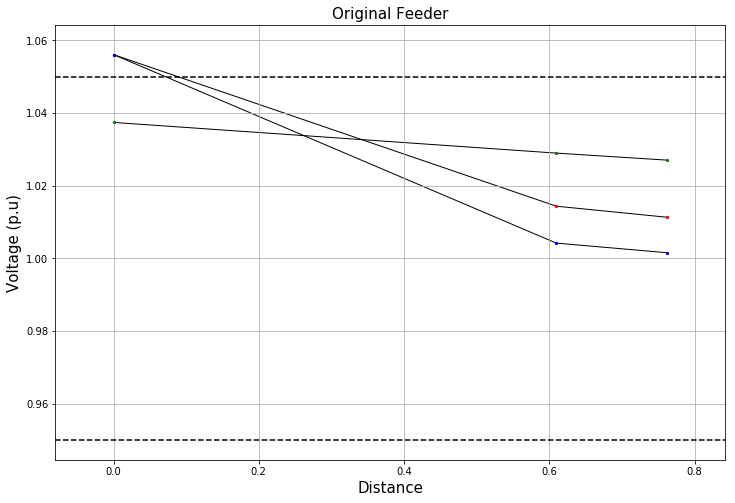

In [16]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.title('Original Feeder', fontsize=15)
#plt.savefig('./J1_origin/voltage_profile_origin.png')

In [17]:
redirect_transformed_master_file(feeder)

In [18]:
static_stats()

------------------------
N Capacitors = 2
N CapControls = 0
N Lines = 12
N Loads = 15
N RegControls = 3
N Transformers = 5
N Buses = 16
------------------------


In [19]:
! rm ./IEEE_13_nodes_transformed/voltages_transformed.csv

In [20]:
dss.dss_lib.DSSPut_Command('Export voltages ./IEEE_13_nodes_transformed/voltages_transformed.csv')
voltages_transformed=pd.read_csv('./IEEE_13_nodes_transformed/voltages_transformed.csv')
voltages_transformed

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,SOURCEBUS,115.00,1,66393.500,30.0,0.99997,2,66394.900,-90.0,0.99999,3,66392.000,150.0,0.99995
1,650,4.16,1,2401.560,0.0,0.99991,2,2401.710,-120.0,0.99997,3,2401.610,120.0,0.99993
2,RG60,4.16,1,2536.360,0.0,1.05600,2,2491.570,-120.0,1.03740,3,2536.400,120.0,1.05600
3,633,4.16,1,2428.890,-2.6,1.01130,2,2466.670,-121.8,1.02700,3,2405.460,117.8,1.00150
4,634,0.48,1,273.566,-3.3,0.98715,2,279.462,-122.3,1.00840,3,272.262,117.3,0.98244
5,632,4.16,1,2436.200,-2.5,1.01430,2,2471.300,-121.8,1.02890,3,2411.820,117.8,1.00420
6,692,4.16,1,2360.140,-5.4,0.98266,2,2498.560,-122.4,1.04030,3,2317.190,116.0,0.96478
7,675,4.16,1,2344.460,-5.6,0.97614,2,2504.220,-122.6,1.04270,3,2312.540,116.0,0.96284
8,670,4.16,1,2411.410,-3.5,1.00400,2,2478.330,-122.0,1.03190,3,2377.120,117.1,0.98973
9,671,4.16,1,2360.410,-5.4,0.98278,2,2498.520,-122.4,1.04030,3,2317.390,116.0,0.96486


In [21]:
compare=compare_voltages_pu(voltages_origin, voltages_transformed)
compare_a=compare_angles(voltages_origin, voltages_transformed)
print compare
print compare_a

[[ 0.99999  0.99999]
 [ 0.99997  0.99997]
 [ 1.056    1.056  ]
 [ 1.027    1.027  ]
 [ 1.0084   1.0084 ]
 [ 1.0403   1.0403 ]
 [ 1.0197   1.0197 ]
 [ 1.018    1.018  ]
 [ 1.0403   1.0403 ]
 [ 1.0427   1.0426 ]
 [ 0.96082  0.96082]
 [ 0.97531  0.97533]
 [ 1.0319   1.0319 ]
 [ 1.0289   1.0289 ]
 [ 1.0403   1.0403 ]
 [ 0.98085  0.98087]]
[[ 150.   150. ]
 [ 120.   120. ]
 [ 120.   120. ]
 [ 117.8  117.8]
 [ 117.3  117.3]
 [ 116.   116. ]
 [ 117.8  117.8]
 [ 117.8  117.8]
 [ 116.   116. ]
 [ 116.   116. ]
 [ 115.7  115.7]
 [   0.     0. ]
 [ 117.1  117.1]
 [ 117.8  117.8]
 [ 116.   116. ]
 [ 115.9  115.9]]


/Users/ngensoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


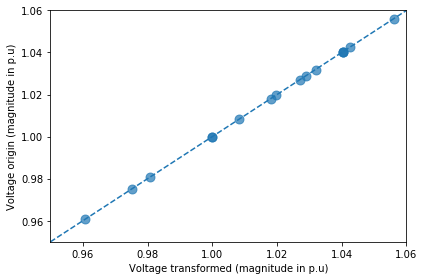

In [22]:
x_min=.95; x_max=1.06
y_min=.95; y_max=1.06
X=np.linspace(x_min,x_max,1000)
plt.scatter(compare[:,0],compare[:,1], s=80, alpha=.7)
plt.plot(X,X,'--')
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.xlabel('Voltage transformed (magnitude in p.u)')
plt.ylabel('Voltage origin (magnitude in p.u)')
plt.tight_layout()
#plt.savefig('./13_nodes_voltages_scatter.png')

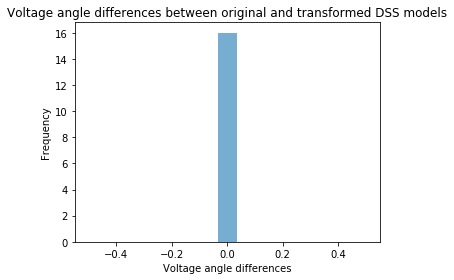

In [23]:
plt.hist(np.abs(compare_a[:,0]-compare_a[:,1]), bins=15, alpha=.6)
plt.title('Voltage angle differences between original and transformed DSS models')
plt.xlabel('Voltage angle differences')
plt.ylabel('Frequency')
plt.tight_layout()

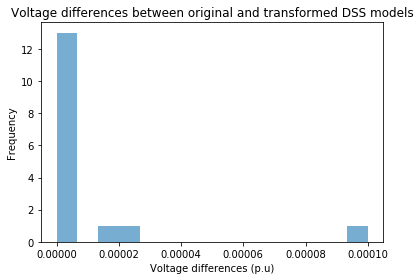

In [24]:
plt.hist(np.abs(compare[:,0]-compare[:,1]), bins=15, alpha=.6)
plt.title('Voltage differences between original and transformed DSS models')
plt.xlabel('Voltage differences (p.u)')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('./13_nodes_voltages_hist.png')

#  --------- IEEE 37 Nodes Feeder ---------

In [25]:
feeder=2

In [26]:
m=Store()
reader=Reader()
reader.build_opendssdirect(get_master_file(feeder))
reader.set_dss_file_names({'Nodes':get_bus_file(feeder)})
reader.parse(m, verbose=True)

2017-10-16 16:45:24,753 - OpenDSS_reader - WARNING - Could not parse line : 

2017-10-16 16:45:24,753 - OpenDSS_reader - WARNING - Could not parse line : 

2017-10-16 16:45:24,759 - OpenDSS_reader - WARNING - Could not cast coordinates None, None for bus None
2017-10-16 16:45:24,759 - OpenDSS_reader - WARNING - Could not cast coordinates None, None for bus None


Parsing the nodes...
Succesful!
Parsing the transformers...
Succesful!
Parsing the loads...
Succesful!
Parsing the lines...
Succesful!
Parsing the regulators...
Succesful!
Parsing the capacitors...
Succesful!
Parsing done.


1

In [27]:
writer=Writer(linecodes_flag=True, output_path=get_output_path(feeder))
writer.write(m, verbose=True)

Writing the bus coordinates...
Succesful!
Writing the transformers...
Succesful!
Writing the regulators...
Succesful!
Writing the capacitors...
Succesful!
Writing the loads...
Succesful!
Writting the linecodes...
Succesful!
Writting the WireData...
Succesful!
Writting the linegeometries...
Succesful!
Writting the lines...
Succesful!
Writting done.


1

In [28]:
dss.dss_lib.DSSPut_Command('redirect {path}'.format(path=get_master_file(feeder)))
dss.dss_lib.DSSPut_Command('Export voltages ./IEEE_37_nodes_origin/voltages_origin.csv')
voltages_origin=pd.read_csv('./IEEE_37_nodes_origin/voltages_origin.csv')
voltages_origin.head()

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,SOURCEBUS,230.00,1,132789.000,0.0,0.99999,2,132789.000,-120.0,0.99999,3,132789.000,120.0,0.99999
1,799,4.80,1,2413.860,-9.0,0.87103,2,2839.520,-123.8,1.02460,3,2505.630,119.6,0.90414
2,709,4.80,1,2632.730,-4.7,0.95000,2,2768.300,-124.1,0.99893,3,2726.640,113.2,0.98389
3,775,0.48,1,263.272,-4.7,0.95000,2,276.809,-124.1,0.99885,3,272.686,113.2,0.98397
4,701,4.80,1,2698.190,-4.4,0.97363,2,2812.030,-124.0,1.01470,3,2772.670,113.8,1.00050


In [29]:
static_stats()

------------------------
N Capacitors = 0
N CapControls = 0
N Lines = 36
N Loads = 30
N RegControls = 2
N Transformers = 4
N Buses = 39
------------------------


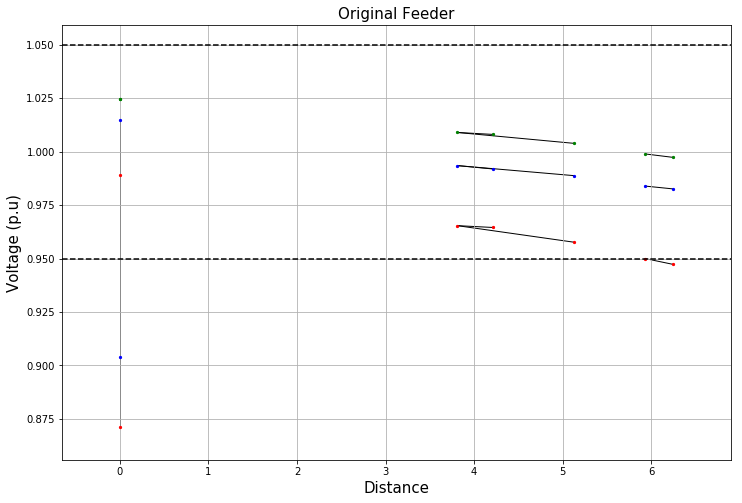

In [30]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.title('Original Feeder', fontsize=15)
#plt.savefig('./J1_origin/voltage_profile_origin.png')

In [31]:
redirect_transformed_master_file(feeder)
static_stats()

------------------------
N Capacitors = 0
N CapControls = 0
N Lines = 36
N Loads = 30
N RegControls = 2
N Transformers = 4
N Buses = 39
------------------------


In [32]:
dss.dss_lib.DSSPut_Command('Export voltages ./IEEE_37_nodes_transformed/voltages_transformed.csv')
voltages_transformed=pd.read_csv('./IEEE_37_nodes_transformed/voltages_transformed.csv')
voltages_transformed

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,SOURCEBUS,230.00,1,132789.00,0.0,0.99999,2,132789.000,-120.0,0.99999,3,132789.000,120.0,0.99999
1,799,4.80,1,2394.82,-9.0,0.86416,2,2852.130,-124.2,1.02920,3,2513.990,119.9,0.90716
2,799R,4.80,1,2774.43,-4.5,1.00110,2,2852.130,-124.2,1.02920,3,2828.180,114.3,1.02050
3,709,4.80,1,2666.80,-4.9,0.96230,2,2781.140,-124.4,1.00360,3,2743.480,113.2,0.98997
4,775,0.48,1,266.64,-4.9,0.96215,2,278.133,-124.5,1.00360,3,274.368,113.3,0.99004
5,744,4.80,1,2682.90,-4.9,0.96811,2,2790.700,-124.5,1.00700,3,2754.160,113.4,0.99382
6,728,4.80,1,2681.80,-4.9,0.96771,2,2789.640,-124.5,1.00660,3,2753.110,113.4,0.99344
7,737,4.80,1,2632.22,-5.0,0.94982,2,2759.790,-124.2,0.99585,3,2728.410,113.0,0.98453
8,738,4.80,1,2628.44,-5.0,0.94846,2,2757.940,-124.2,0.99519,3,2726.720,113.0,0.98392
9,734,4.80,1,2641.26,-4.9,0.95308,2,2765.920,-124.3,0.99807,3,2730.960,113.1,0.98545


In [33]:
compare=compare_voltages_pu(voltages_origin, voltages_transformed)
compare

/Users/ngensoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([[ 0.99999,  0.99999],
       [ 1.0292 ,  1.0246 ],
       [ 1.0036 ,  0.99893],
       [ 1.0036 ,  0.99885],
       [ 1.0193 ,  1.0147 ],
       [ 1.0136 ,  1.009  ],
       [ 1.0126 ,  1.0081 ],
       [ 1.012  ,  1.0074 ],
       [ 1.0085 ,  1.0039 ],
       [ 1.0076 ,  1.003  ],
       [ 1.0048 ,  1.0002 ],
       [ 1.0097 ,  1.0051 ],
       [ 1.0095 ,  1.0049 ],
       [ 1.0074 ,  1.0028 ],
       [ 1.0119 ,  1.0073 ],
       [ 1.0126 ,  1.0081 ],
       [ 1.0071 ,  1.0025 ],
       [ 1.0068 ,  1.0022 ],
       [ 1.0032 ,  0.99864],
       [ 1.0024 ,  0.99784],
       [ 1.0028 ,  0.99822],
       [ 1.0019 ,  0.99729],
       [ 1.0003 ,  0.99566],
       [ 1.0019 ,  0.99729],
       [ 1.0029 ,  0.99829],
       [ 0.99752,  0.99287],
       [ 0.99752,  0.99287],
       [ 0.99617,  0.99152],
       [ 0.99519,  0.99051],
       [ 0.99519,  0.99051],
       [ 0.99519,  0.99051],
       [ 1.0086 ,  1.004  ],
       [ 1.007  ,  1.0024 ],
       [ 0.99807,  0.99341],
       [ 0.995

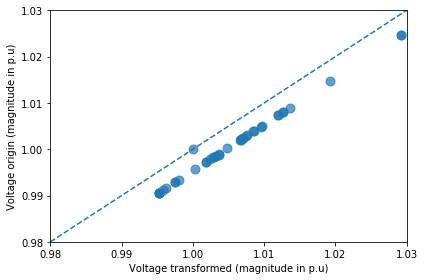

In [34]:
x_min=.98; x_max=1.03
y_min=.98; y_max=1.03
X=np.linspace(x_min,x_max,1000)
plt.scatter(compare[:,0],compare[:,1], s=80, alpha=.7)
plt.plot(X,X,'--')
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.xlabel('Voltage transformed (magnitude in p.u)')
plt.ylabel('Voltage origin (magnitude in p.u)')
plt.tight_layout()
#plt.savefig('./37_nodes_voltages_scatter.png')

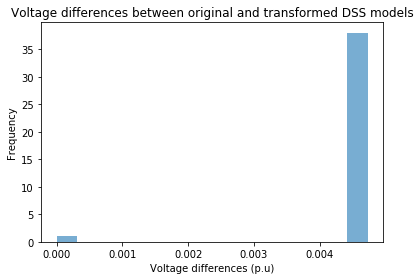

In [35]:
plt.hist(np.abs(compare[:,0]-compare[:,1])/np.max(compare,axis=1), bins=15, alpha=.6)
plt.title('Voltage differences between original and transformed DSS models')
plt.xlabel('Voltage differences (p.u)')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('./37_nodes_voltages_hist.png')

# --------- J1 Feeder ---------

In [36]:
feeder=1

In [37]:
m=Store()
reader=Reader()
reader.build_opendssdirect(get_master_file(feeder))
reader.set_dss_file_names({'Nodes':get_bus_file(feeder)})
reader.parse(m, verbose=True)

Parsing the nodes...
Succesful!
Parsing the transformers...
Succesful!
Parsing the loads...
Succesful!
Parsing the lines...


2017-10-16 16:46:00,546 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust7
2017-10-16 16:46:00,546 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust7
2017-10-16 16:46:00,546 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust7
2017-10-16 16:46:00,593 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust6
2017-10-16 16:46:00,593 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust6
2017-10-16 16:46:00,593 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust6
2017-10-16 16:46:00,643 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust5
2017-10-16 16:46:00,643 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust5
2017-10-16 16:46:00,643 - OpenDSS_reader - WARNING - Duplicate object Line b24288-1-c_cust5
2017-10-16 16:46:00,691 - OpenDSS_reader - WARNING - Duplicate object Line b42005-1-a_cust1
2017-10-16 16:46:00,691 - OpenDSS_reader - WARNING - Duplicate object Line b4200

2017-10-16 16:46:02,647 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust2
2017-10-16 16:46:02,647 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust2
2017-10-16 16:46:02,647 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust2
2017-10-16 16:46:02,693 - OpenDSS_reader - WARNING - Duplicate object Line 5839828569-1-c_cust1
2017-10-16 16:46:02,693 - OpenDSS_reader - WARNING - Duplicate object Line 5839828569-1-c_cust1
2017-10-16 16:46:02,693 - OpenDSS_reader - WARNING - Duplicate object Line 5839828569-1-c_cust1
2017-10-16 16:46:02,768 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust1
2017-10-16 16:46:02,768 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust1
2017-10-16 16:46:02,768 - OpenDSS_reader - WARNING - Duplicate object Line b19069-1-c_cust1
2017-10-16 16:46:02,810 - OpenDSS_reader - WARNING - Duplicate object Line b10227-1-a_cust2
2017-10-16 16:46:02,810 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:04,576 - OpenDSS_reader - WARNING - Duplicate object Line b22571-1-c_cust1
2017-10-16 16:46:04,623 - OpenDSS_reader - WARNING - Duplicate object Line b28786-1-c_cust1
2017-10-16 16:46:04,623 - OpenDSS_reader - WARNING - Duplicate object Line b28786-1-c_cust1
2017-10-16 16:46:04,623 - OpenDSS_reader - WARNING - Duplicate object Line b28786-1-c_cust1
2017-10-16 16:46:04,700 - OpenDSS_reader - WARNING - Duplicate object Line 5905528285-1-c_cust1
2017-10-16 16:46:04,700 - OpenDSS_reader - WARNING - Duplicate object Line 5905528285-1-c_cust1
2017-10-16 16:46:04,700 - OpenDSS_reader - WARNING - Duplicate object Line 5905528285-1-c_cust1
2017-10-16 16:46:04,836 - OpenDSS_reader - WARNING - Duplicate object Line b46969-1-a_cust1
2017-10-16 16:46:04,836 - OpenDSS_reader - WARNING - Duplicate object Line b46969-1-a_cust1
2017-10-16 16:46:04,836 - OpenDSS_reader - WARNING - Duplicate object Line b46969-1-a_cust1
2017-10-16 16:46:04,914 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:08,292 - OpenDSS_reader - WARNING - Duplicate object Line b55824-1-c_cust1
2017-10-16 16:46:08,292 - OpenDSS_reader - WARNING - Duplicate object Line b55824-1-c_cust1
2017-10-16 16:46:08,402 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust1
2017-10-16 16:46:08,402 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust1
2017-10-16 16:46:08,402 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust1
2017-10-16 16:46:08,448 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust3
2017-10-16 16:46:08,448 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust3
2017-10-16 16:46:08,448 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust3
2017-10-16 16:46:08,494 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust2
2017-10-16 16:46:08,494 - OpenDSS_reader - WARNING - Duplicate object Line b44433-1-c_cust2
2017-10-16 16:46:08,494 - OpenDSS_reader - WARNING - Duplicate object Line b4443

2017-10-16 16:46:10,415 - OpenDSS_reader - WARNING - Duplicate object Line b41859-1-b_cust2
2017-10-16 16:46:10,415 - OpenDSS_reader - WARNING - Duplicate object Line b41859-1-b_cust2
2017-10-16 16:46:10,415 - OpenDSS_reader - WARNING - Duplicate object Line b41859-1-b_cust2
2017-10-16 16:46:10,532 - OpenDSS_reader - WARNING - Duplicate object Line b59935-1-a_cust2
2017-10-16 16:46:10,532 - OpenDSS_reader - WARNING - Duplicate object Line b59935-1-a_cust2
2017-10-16 16:46:10,532 - OpenDSS_reader - WARNING - Duplicate object Line b59935-1-a_cust2
2017-10-16 16:46:10,569 - OpenDSS_reader - WARNING - Duplicate object Line g40999-1-c_cust1
2017-10-16 16:46:10,569 - OpenDSS_reader - WARNING - Duplicate object Line g40999-1-c_cust1
2017-10-16 16:46:10,569 - OpenDSS_reader - WARNING - Duplicate object Line g40999-1-c_cust1
2017-10-16 16:46:10,609 - OpenDSS_reader - WARNING - Duplicate object Line b59935-1-a_cust1
2017-10-16 16:46:10,609 - OpenDSS_reader - WARNING - Duplicate object Line b5993

2017-10-16 16:46:12,360 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust1
2017-10-16 16:46:12,360 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust1
2017-10-16 16:46:12,360 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust1
2017-10-16 16:46:12,403 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust3
2017-10-16 16:46:12,403 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust3
2017-10-16 16:46:12,403 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust3
2017-10-16 16:46:12,447 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust2
2017-10-16 16:46:12,447 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust2
2017-10-16 16:46:12,447 - OpenDSS_reader - WARNING - Duplicate object Line b19066-1-c_cust2
2017-10-16 16:46:12,491 - OpenDSS_reader - WARNING - Duplicate object Line b14647-1-b_cust4
2017-10-16 16:46:12,491 - OpenDSS_reader - WARNING - Duplicate object Line b1464

2017-10-16 16:46:15,080 - OpenDSS_reader - WARNING - Duplicate object Line b5206-1-c_cust1
2017-10-16 16:46:15,080 - OpenDSS_reader - WARNING - Duplicate object Line b5206-1-c_cust1
2017-10-16 16:46:15,080 - OpenDSS_reader - WARNING - Duplicate object Line b5206-1-c_cust1
2017-10-16 16:46:15,128 - OpenDSS_reader - WARNING - Duplicate object Line b48186-1-c_cust1
2017-10-16 16:46:15,128 - OpenDSS_reader - WARNING - Duplicate object Line b48186-1-c_cust1
2017-10-16 16:46:15,128 - OpenDSS_reader - WARNING - Duplicate object Line b48186-1-c_cust1
2017-10-16 16:46:15,207 - OpenDSS_reader - WARNING - Duplicate object Line b61159-1-b_cust1
2017-10-16 16:46:15,207 - OpenDSS_reader - WARNING - Duplicate object Line b61159-1-b_cust1
2017-10-16 16:46:15,207 - OpenDSS_reader - WARNING - Duplicate object Line b61159-1-b_cust1
2017-10-16 16:46:15,249 - OpenDSS_reader - WARNING - Duplicate object Line b40572-1-c_cust1
2017-10-16 16:46:15,249 - OpenDSS_reader - WARNING - Duplicate object Line b40572-1

2017-10-16 16:46:17,371 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust4
2017-10-16 16:46:17,423 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust5
2017-10-16 16:46:17,423 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust5
2017-10-16 16:46:17,423 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust5
2017-10-16 16:46:17,467 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust2
2017-10-16 16:46:17,467 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust2
2017-10-16 16:46:17,467 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust2
2017-10-16 16:46:17,512 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust3
2017-10-16 16:46:17,512 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust3
2017-10-16 16:46:17,512 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust3
2017-10-16 16:46:17,558 - OpenDSS_reader - WARNING - Duplicate object Line b4715-1-b_cust1

2017-10-16 16:46:19,511 - OpenDSS_reader - WARNING - Duplicate object Line b4819-1-c_cust3
2017-10-16 16:46:19,558 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust2
2017-10-16 16:46:19,558 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust2
2017-10-16 16:46:19,558 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust2
2017-10-16 16:46:19,603 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust3
2017-10-16 16:46:19,603 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust3
2017-10-16 16:46:19,603 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust3
2017-10-16 16:46:19,648 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust1
2017-10-16 16:46:19,648 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust1
2017-10-16 16:46:19,648 - OpenDSS_reader - WARNING - Duplicate object Line b17988-1-c_cust1
2017-10-16 16:46:19,760 - OpenDSS_reader - WARNING - Duplicate object Line b18835

2017-10-16 16:46:21,518 - OpenDSS_reader - WARNING - Duplicate object Line b32823-1-c_cust1
2017-10-16 16:46:21,518 - OpenDSS_reader - WARNING - Duplicate object Line b32823-1-c_cust1
2017-10-16 16:46:21,672 - OpenDSS_reader - WARNING - Duplicate object Line g44012-1-a_cust1
2017-10-16 16:46:21,672 - OpenDSS_reader - WARNING - Duplicate object Line g44012-1-a_cust1
2017-10-16 16:46:21,672 - OpenDSS_reader - WARNING - Duplicate object Line g44012-1-a_cust1
2017-10-16 16:46:21,719 - OpenDSS_reader - WARNING - Duplicate object Line b22469-1-c_cust2
2017-10-16 16:46:21,719 - OpenDSS_reader - WARNING - Duplicate object Line b22469-1-c_cust2
2017-10-16 16:46:21,719 - OpenDSS_reader - WARNING - Duplicate object Line b22469-1-c_cust2
2017-10-16 16:46:21,763 - OpenDSS_reader - WARNING - Duplicate object Line b22469-1-c_cust3
2017-10-16 16:46:21,763 - OpenDSS_reader - WARNING - Duplicate object Line b22469-1-c_cust3
2017-10-16 16:46:21,763 - OpenDSS_reader - WARNING - Duplicate object Line b2246

2017-10-16 16:46:24,625 - OpenDSS_reader - WARNING - Duplicate object Line b23205-1-a_cust1
2017-10-16 16:46:24,625 - OpenDSS_reader - WARNING - Duplicate object Line b23205-1-a_cust1
2017-10-16 16:46:24,625 - OpenDSS_reader - WARNING - Duplicate object Line b23205-1-a_cust1
2017-10-16 16:46:24,666 - OpenDSS_reader - WARNING - Duplicate object Line b47846-1-c_cust1
2017-10-16 16:46:24,666 - OpenDSS_reader - WARNING - Duplicate object Line b47846-1-c_cust1
2017-10-16 16:46:24,666 - OpenDSS_reader - WARNING - Duplicate object Line b47846-1-c_cust1
2017-10-16 16:46:24,711 - OpenDSS_reader - WARNING - Duplicate object Line b24157-1-c_cust1
2017-10-16 16:46:24,711 - OpenDSS_reader - WARNING - Duplicate object Line b24157-1-c_cust1
2017-10-16 16:46:24,711 - OpenDSS_reader - WARNING - Duplicate object Line b24157-1-c_cust1
2017-10-16 16:46:24,755 - OpenDSS_reader - WARNING - Duplicate object Line b4878-1-a_cust1
2017-10-16 16:46:24,755 - OpenDSS_reader - WARNING - Duplicate object Line b4878-

2017-10-16 16:46:26,875 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust2
2017-10-16 16:46:26,875 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust2
2017-10-16 16:46:26,875 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust2
2017-10-16 16:46:26,921 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust3
2017-10-16 16:46:26,921 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust3
2017-10-16 16:46:26,921 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust3
2017-10-16 16:46:26,969 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust1
2017-10-16 16:46:26,969 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust1
2017-10-16 16:46:26,969 - OpenDSS_reader - WARNING - Duplicate object Line b46252-1-c_cust1
2017-10-16 16:46:27,012 - OpenDSS_reader - WARNING - Duplicate object Line b8019-1-c_cust1
2017-10-16 16:46:27,012 - OpenDSS_reader - WARNING - Duplicate object Line b8019-

2017-10-16 16:46:28,650 - OpenDSS_reader - WARNING - Duplicate object Line b4806-1-b_cust1
2017-10-16 16:46:28,650 - OpenDSS_reader - WARNING - Duplicate object Line b4806-1-b_cust1
2017-10-16 16:46:28,650 - OpenDSS_reader - WARNING - Duplicate object Line b4806-1-b_cust1
2017-10-16 16:46:28,730 - OpenDSS_reader - WARNING - Duplicate object Line b5177-1-b_cust1
2017-10-16 16:46:28,730 - OpenDSS_reader - WARNING - Duplicate object Line b5177-1-b_cust1
2017-10-16 16:46:28,730 - OpenDSS_reader - WARNING - Duplicate object Line b5177-1-b_cust1
2017-10-16 16:46:28,774 - OpenDSS_reader - WARNING - Duplicate object Line b4802-1-a_cust8
2017-10-16 16:46:28,774 - OpenDSS_reader - WARNING - Duplicate object Line b4802-1-a_cust8
2017-10-16 16:46:28,774 - OpenDSS_reader - WARNING - Duplicate object Line b4802-1-a_cust8
2017-10-16 16:46:28,855 - OpenDSS_reader - WARNING - Duplicate object Line b12541-1-a_cust1
2017-10-16 16:46:28,855 - OpenDSS_reader - WARNING - Duplicate object Line b12541-1-a_cus

2017-10-16 16:46:31,254 - OpenDSS_reader - WARNING - Duplicate object Line b66452-1-a_cust2
2017-10-16 16:46:31,254 - OpenDSS_reader - WARNING - Duplicate object Line b66452-1-a_cust2
2017-10-16 16:46:31,254 - OpenDSS_reader - WARNING - Duplicate object Line b66452-1-a_cust2
2017-10-16 16:46:31,331 - OpenDSS_reader - WARNING - Duplicate object Line b60427-1-b_cust1
2017-10-16 16:46:31,331 - OpenDSS_reader - WARNING - Duplicate object Line b60427-1-b_cust1
2017-10-16 16:46:31,331 - OpenDSS_reader - WARNING - Duplicate object Line b60427-1-b_cust1
2017-10-16 16:46:31,377 - OpenDSS_reader - WARNING - Duplicate object Line b18987-1-c_cust1
2017-10-16 16:46:31,377 - OpenDSS_reader - WARNING - Duplicate object Line b18987-1-c_cust1
2017-10-16 16:46:31,377 - OpenDSS_reader - WARNING - Duplicate object Line b18987-1-c_cust1
2017-10-16 16:46:31,463 - OpenDSS_reader - WARNING - Duplicate object Line b18987-1-c_cust3
2017-10-16 16:46:31,463 - OpenDSS_reader - WARNING - Duplicate object Line b1898

2017-10-16 16:46:33,532 - OpenDSS_reader - WARNING - Duplicate object Line b41084-1-b_cust1
2017-10-16 16:46:33,574 - OpenDSS_reader - WARNING - Duplicate object Line b17215-1-c_cust1
2017-10-16 16:46:33,574 - OpenDSS_reader - WARNING - Duplicate object Line b17215-1-c_cust1
2017-10-16 16:46:33,574 - OpenDSS_reader - WARNING - Duplicate object Line b17215-1-c_cust1
2017-10-16 16:46:33,628 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust3
2017-10-16 16:46:33,628 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust3
2017-10-16 16:46:33,628 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust3
2017-10-16 16:46:33,674 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust2
2017-10-16 16:46:33,674 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust2
2017-10-16 16:46:33,674 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_cust2
2017-10-16 16:46:33,720 - OpenDSS_reader - WARNING - Duplicate object Line b4885-1-c_c

2017-10-16 16:46:35,507 - OpenDSS_reader - WARNING - Duplicate object Line b13654-1-c_cust11
2017-10-16 16:46:35,507 - OpenDSS_reader - WARNING - Duplicate object Line b13654-1-c_cust11
2017-10-16 16:46:35,552 - OpenDSS_reader - WARNING - Duplicate object Line b394-1-b_cust2
2017-10-16 16:46:35,552 - OpenDSS_reader - WARNING - Duplicate object Line b394-1-b_cust2
2017-10-16 16:46:35,552 - OpenDSS_reader - WARNING - Duplicate object Line b394-1-b_cust2
2017-10-16 16:46:35,626 - OpenDSS_reader - WARNING - Duplicate object Line b19003-1-c_cust1
2017-10-16 16:46:35,626 - OpenDSS_reader - WARNING - Duplicate object Line b19003-1-c_cust1
2017-10-16 16:46:35,626 - OpenDSS_reader - WARNING - Duplicate object Line b19003-1-c_cust1
2017-10-16 16:46:35,703 - OpenDSS_reader - WARNING - Duplicate object Line b39820-1-c_cust1
2017-10-16 16:46:35,703 - OpenDSS_reader - WARNING - Duplicate object Line b39820-1-c_cust1
2017-10-16 16:46:35,703 - OpenDSS_reader - WARNING - Duplicate object Line b39820-1-

2017-10-16 16:46:37,855 - OpenDSS_reader - WARNING - Duplicate object Line b36181-1-c_cust1
2017-10-16 16:46:37,855 - OpenDSS_reader - WARNING - Duplicate object Line b36181-1-c_cust1
2017-10-16 16:46:37,855 - OpenDSS_reader - WARNING - Duplicate object Line b36181-1-c_cust1
2017-10-16 16:46:37,898 - OpenDSS_reader - WARNING - Duplicate object Line b41858-1-b_cust1
2017-10-16 16:46:37,898 - OpenDSS_reader - WARNING - Duplicate object Line b41858-1-b_cust1
2017-10-16 16:46:37,898 - OpenDSS_reader - WARNING - Duplicate object Line b41858-1-b_cust1
2017-10-16 16:46:37,945 - OpenDSS_reader - WARNING - Duplicate object Line 5851028310-1-b_cust1
2017-10-16 16:46:37,945 - OpenDSS_reader - WARNING - Duplicate object Line 5851028310-1-b_cust1
2017-10-16 16:46:37,945 - OpenDSS_reader - WARNING - Duplicate object Line 5851028310-1-b_cust1
2017-10-16 16:46:37,991 - OpenDSS_reader - WARNING - Duplicate object Line b28785-1-c_cust2
2017-10-16 16:46:37,991 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:40,839 - OpenDSS_reader - WARNING - Duplicate object Line b57846-1-c_cust1
2017-10-16 16:46:40,839 - OpenDSS_reader - WARNING - Duplicate object Line b57846-1-c_cust1
2017-10-16 16:46:40,839 - OpenDSS_reader - WARNING - Duplicate object Line b57846-1-c_cust1
2017-10-16 16:46:40,887 - OpenDSS_reader - WARNING - Duplicate object Line b41086-1-c_cust1
2017-10-16 16:46:40,887 - OpenDSS_reader - WARNING - Duplicate object Line b41086-1-c_cust1
2017-10-16 16:46:40,887 - OpenDSS_reader - WARNING - Duplicate object Line b41086-1-c_cust1
2017-10-16 16:46:40,998 - OpenDSS_reader - WARNING - Duplicate object Line g34723-1-c_cust1
2017-10-16 16:46:40,998 - OpenDSS_reader - WARNING - Duplicate object Line g34723-1-c_cust1
2017-10-16 16:46:40,998 - OpenDSS_reader - WARNING - Duplicate object Line g34723-1-c_cust1
2017-10-16 16:46:41,049 - OpenDSS_reader - WARNING - Duplicate object Line b56625-1-a_cust1
2017-10-16 16:46:41,049 - OpenDSS_reader - WARNING - Duplicate object Line b5662

2017-10-16 16:46:42,602 - OpenDSS_reader - WARNING - Duplicate object Line 5883627823-1-b_cust1
2017-10-16 16:46:42,712 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust1
2017-10-16 16:46:42,712 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust1
2017-10-16 16:46:42,712 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust1
2017-10-16 16:46:42,756 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust2
2017-10-16 16:46:42,756 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust2
2017-10-16 16:46:42,756 - OpenDSS_reader - WARNING - Duplicate object Line b46973-1-a_cust2
2017-10-16 16:46:42,798 - OpenDSS_reader - WARNING - Duplicate object Line g42435-1-a_cust1
2017-10-16 16:46:42,798 - OpenDSS_reader - WARNING - Duplicate object Line g42435-1-a_cust1
2017-10-16 16:46:42,798 - OpenDSS_reader - WARNING - Duplicate object Line g42435-1-a_cust1
2017-10-16 16:46:42,844 - OpenDSS_reader - WARNING - Duplicate object Line b

2017-10-16 16:46:45,090 - OpenDSS_reader - WARNING - Duplicate object Line g35573-1-a_cust1
2017-10-16 16:46:45,090 - OpenDSS_reader - WARNING - Duplicate object Line g35573-1-a_cust1
2017-10-16 16:46:45,169 - OpenDSS_reader - WARNING - Duplicate object Line b17925-1-b_cust1
2017-10-16 16:46:45,169 - OpenDSS_reader - WARNING - Duplicate object Line b17925-1-b_cust1
2017-10-16 16:46:45,169 - OpenDSS_reader - WARNING - Duplicate object Line b17925-1-b_cust1
2017-10-16 16:46:45,213 - OpenDSS_reader - WARNING - Duplicate object Line 5934828209-1-c_cust1
2017-10-16 16:46:45,213 - OpenDSS_reader - WARNING - Duplicate object Line 5934828209-1-c_cust1
2017-10-16 16:46:45,213 - OpenDSS_reader - WARNING - Duplicate object Line 5934828209-1-c_cust1
2017-10-16 16:46:45,261 - OpenDSS_reader - WARNING - Duplicate object Line b13930-1-c_cust2
2017-10-16 16:46:45,261 - OpenDSS_reader - WARNING - Duplicate object Line b13930-1-c_cust2
2017-10-16 16:46:45,261 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:47,145 - OpenDSS_reader - WARNING - Duplicate object Line b56665-1-b_cust1
2017-10-16 16:46:47,145 - OpenDSS_reader - WARNING - Duplicate object Line b56665-1-b_cust1
2017-10-16 16:46:47,192 - OpenDSS_reader - WARNING - Duplicate object Line g41826-1-b_cust1
2017-10-16 16:46:47,192 - OpenDSS_reader - WARNING - Duplicate object Line g41826-1-b_cust1
2017-10-16 16:46:47,192 - OpenDSS_reader - WARNING - Duplicate object Line g41826-1-b_cust1
2017-10-16 16:46:47,332 - OpenDSS_reader - WARNING - Duplicate object Line b12329-1-a_cust1
2017-10-16 16:46:47,332 - OpenDSS_reader - WARNING - Duplicate object Line b12329-1-a_cust1
2017-10-16 16:46:47,332 - OpenDSS_reader - WARNING - Duplicate object Line b12329-1-a_cust1
2017-10-16 16:46:47,513 - OpenDSS_reader - WARNING - Duplicate object Line b23211-1-c_cust4
2017-10-16 16:46:47,513 - OpenDSS_reader - WARNING - Duplicate object Line b23211-1-c_cust4
2017-10-16 16:46:47,513 - OpenDSS_reader - WARNING - Duplicate object Line b2321

2017-10-16 16:46:49,179 - OpenDSS_reader - WARNING - Duplicate object Line b28551-1-b_cust1
2017-10-16 16:46:49,179 - OpenDSS_reader - WARNING - Duplicate object Line b28551-1-b_cust1
2017-10-16 16:46:49,262 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_cust1
2017-10-16 16:46:49,262 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_cust1
2017-10-16 16:46:49,262 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_cust1
2017-10-16 16:46:49,309 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1-b_cust4
2017-10-16 16:46:49,309 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1-b_cust4
2017-10-16 16:46:49,309 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1-b_cust4
2017-10-16 16:46:49,351 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1-b_cust5
2017-10-16 16:46:49,351 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1-b_cust5
2017-10-16 16:46:49,351 - OpenDSS_reader - WARNING - Duplicate object Line b18847-1

2017-10-16 16:46:50,774 - OpenDSS_reader - WARNING - Duplicate object Line b66604-1-c_cust2
2017-10-16 16:46:50,774 - OpenDSS_reader - WARNING - Duplicate object Line b66604-1-c_cust2
2017-10-16 16:46:50,818 - OpenDSS_reader - WARNING - Duplicate object Line b18887-1-a_cust1
2017-10-16 16:46:50,818 - OpenDSS_reader - WARNING - Duplicate object Line b18887-1-a_cust1
2017-10-16 16:46:50,818 - OpenDSS_reader - WARNING - Duplicate object Line b18887-1-a_cust1
2017-10-16 16:46:50,863 - OpenDSS_reader - WARNING - Duplicate object Line 5988528387-1-c_cust1
2017-10-16 16:46:50,863 - OpenDSS_reader - WARNING - Duplicate object Line 5988528387-1-c_cust1
2017-10-16 16:46:50,863 - OpenDSS_reader - WARNING - Duplicate object Line 5988528387-1-c_cust1
2017-10-16 16:46:50,910 - OpenDSS_reader - WARNING - Duplicate object Line b56700-1-a_cust1
2017-10-16 16:46:50,910 - OpenDSS_reader - WARNING - Duplicate object Line b56700-1-a_cust1
2017-10-16 16:46:50,910 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:53,654 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust1
2017-10-16 16:46:53,654 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust1
2017-10-16 16:46:53,654 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust1
2017-10-16 16:46:53,697 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust3
2017-10-16 16:46:53,697 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust3
2017-10-16 16:46:53,697 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust3
2017-10-16 16:46:53,743 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust2
2017-10-16 16:46:53,743 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust2
2017-10-16 16:46:53,743 - OpenDSS_reader - WARNING - Duplicate object Line b31172-1-c_cust2
2017-10-16 16:46:53,787 - OpenDSS_reader - WARNING - Duplicate object Line b19034-1-a_cust2
2017-10-16 16:46:53,787 - OpenDSS_reader - WARNING - Duplicate object Line b1903

2017-10-16 16:46:55,707 - OpenDSS_reader - WARNING - Duplicate object Line 6033928909-1-c_cust1
2017-10-16 16:46:55,707 - OpenDSS_reader - WARNING - Duplicate object Line 6033928909-1-c_cust1
2017-10-16 16:46:55,707 - OpenDSS_reader - WARNING - Duplicate object Line 6033928909-1-c_cust1
2017-10-16 16:46:55,923 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust5
2017-10-16 16:46:55,923 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust5
2017-10-16 16:46:55,923 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust5
2017-10-16 16:46:55,998 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust3
2017-10-16 16:46:55,998 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust3
2017-10-16 16:46:55,998 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust3
2017-10-16 16:46:56,040 - OpenDSS_reader - WARNING - Duplicate object Line b46196-1-a_cust2
2017-10-16 16:46:56,040 - OpenDSS_reader - WARNING - Duplicate objec

2017-10-16 16:46:57,772 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust1
2017-10-16 16:46:57,772 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust1
2017-10-16 16:46:57,772 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust1
2017-10-16 16:46:57,849 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust4
2017-10-16 16:46:57,849 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust4
2017-10-16 16:46:57,849 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust4
2017-10-16 16:46:57,892 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust5
2017-10-16 16:46:57,892 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust5
2017-10-16 16:46:57,892 - OpenDSS_reader - WARNING - Duplicate object Line b4880-1-c_cust5
2017-10-16 16:46:57,933 - OpenDSS_reader - WARNING - Duplicate object Line b4796-1-c_cust1
2017-10-16 16:46:57,933 - OpenDSS_reader - WARNING - Duplicate object Line b4796-1-c_cust1

2017-10-16 16:47:00,026 - OpenDSS_reader - WARNING - Duplicate object Line b4748-1-a_cust1
2017-10-16 16:47:00,026 - OpenDSS_reader - WARNING - Duplicate object Line b4748-1-a_cust1
2017-10-16 16:47:00,026 - OpenDSS_reader - WARNING - Duplicate object Line b4748-1-a_cust1
2017-10-16 16:47:00,104 - OpenDSS_reader - WARNING - Duplicate object Line g43678-1-b_cust1
2017-10-16 16:47:00,104 - OpenDSS_reader - WARNING - Duplicate object Line g43678-1-b_cust1
2017-10-16 16:47:00,104 - OpenDSS_reader - WARNING - Duplicate object Line g43678-1-b_cust1
2017-10-16 16:47:00,148 - OpenDSS_reader - WARNING - Duplicate object Line b13555-1-a_cust2
2017-10-16 16:47:00,148 - OpenDSS_reader - WARNING - Duplicate object Line b13555-1-a_cust2
2017-10-16 16:47:00,148 - OpenDSS_reader - WARNING - Duplicate object Line b13555-1-a_cust2
2017-10-16 16:47:00,189 - OpenDSS_reader - WARNING - Duplicate object Line b13555-1-a_cust1
2017-10-16 16:47:00,189 - OpenDSS_reader - WARNING - Duplicate object Line b13555-1

2017-10-16 16:47:02,221 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust1
2017-10-16 16:47:02,265 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust7
2017-10-16 16:47:02,265 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust7
2017-10-16 16:47:02,265 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust7
2017-10-16 16:47:02,307 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust6
2017-10-16 16:47:02,307 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust6
2017-10-16 16:47:02,307 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust6
2017-10-16 16:47:02,352 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust5
2017-10-16 16:47:02,352 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust5
2017-10-16 16:47:02,352 - OpenDSS_reader - WARNING - Duplicate object Line b24275-1-c_cust5
2017-10-16 16:47:02,397 - OpenDSS_reader - WARNING - Duplicate object Line b2427

2017-10-16 16:47:04,132 - OpenDSS_reader - WARNING - Duplicate object Line b19054-1-c_cust3
2017-10-16 16:47:04,174 - OpenDSS_reader - WARNING - Duplicate object Line b56663-1-b_cust1
2017-10-16 16:47:04,174 - OpenDSS_reader - WARNING - Duplicate object Line b56663-1-b_cust1
2017-10-16 16:47:04,174 - OpenDSS_reader - WARNING - Duplicate object Line b56663-1-b_cust1
2017-10-16 16:47:04,219 - OpenDSS_reader - WARNING - Duplicate object Line b13557-1-a_cust1
2017-10-16 16:47:04,219 - OpenDSS_reader - WARNING - Duplicate object Line b13557-1-a_cust1
2017-10-16 16:47:04,219 - OpenDSS_reader - WARNING - Duplicate object Line b13557-1-a_cust1
2017-10-16 16:47:04,404 - OpenDSS_reader - WARNING - Duplicate object Line g42394-1-c_cust1
2017-10-16 16:47:04,404 - OpenDSS_reader - WARNING - Duplicate object Line g42394-1-c_cust1
2017-10-16 16:47:04,404 - OpenDSS_reader - WARNING - Duplicate object Line g42394-1-c_cust1
2017-10-16 16:47:04,480 - OpenDSS_reader - WARNING - Duplicate object Line b4146

2017-10-16 16:47:06,570 - OpenDSS_reader - WARNING - Duplicate object Line b4889-1-b_cust3
2017-10-16 16:47:06,613 - OpenDSS_reader - WARNING - Duplicate object Line b4889-1-b_cust1
2017-10-16 16:47:06,613 - OpenDSS_reader - WARNING - Duplicate object Line b4889-1-b_cust1
2017-10-16 16:47:06,613 - OpenDSS_reader - WARNING - Duplicate object Line b4889-1-b_cust1
2017-10-16 16:47:06,660 - OpenDSS_reader - WARNING - Duplicate object Line 6038329671-1-a_cust2
2017-10-16 16:47:06,660 - OpenDSS_reader - WARNING - Duplicate object Line 6038329671-1-a_cust2
2017-10-16 16:47:06,660 - OpenDSS_reader - WARNING - Duplicate object Line 6038329671-1-a_cust2
2017-10-16 16:47:06,719 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust6
2017-10-16 16:47:06,719 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust6
2017-10-16 16:47:06,719 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust6
2017-10-16 16:47:06,772 - OpenDSS_reader - WARNING - Duplicate object Line 

2017-10-16 16:47:09,147 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust2
2017-10-16 16:47:09,147 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust2
2017-10-16 16:47:09,191 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust3
2017-10-16 16:47:09,191 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust3
2017-10-16 16:47:09,191 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust3
2017-10-16 16:47:09,234 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust4
2017-10-16 16:47:09,234 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust4
2017-10-16 16:47:09,234 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust4
2017-10-16 16:47:09,280 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust5
2017-10-16 16:47:09,280 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust5
2017-10-16 16:47:09,280 - OpenDSS_reader - WARNING - Duplicate object Line b4861-1-b_cust5

2017-10-16 16:47:11,051 - OpenDSS_reader - WARNING - Duplicate object Line b5218-1-b_cust1
2017-10-16 16:47:11,051 - OpenDSS_reader - WARNING - Duplicate object Line b5218-1-b_cust1
2017-10-16 16:47:11,094 - OpenDSS_reader - WARNING - Duplicate object Line b40572-1-a_cust1
2017-10-16 16:47:11,094 - OpenDSS_reader - WARNING - Duplicate object Line b40572-1-a_cust1
2017-10-16 16:47:11,094 - OpenDSS_reader - WARNING - Duplicate object Line b40572-1-a_cust1
2017-10-16 16:47:11,139 - OpenDSS_reader - WARNING - Duplicate object Line g43792-1-b_cust1
2017-10-16 16:47:11,139 - OpenDSS_reader - WARNING - Duplicate object Line g43792-1-b_cust1
2017-10-16 16:47:11,139 - OpenDSS_reader - WARNING - Duplicate object Line g43792-1-b_cust1
2017-10-16 16:47:11,287 - OpenDSS_reader - WARNING - Duplicate object Line b36183-1-c_cust1
2017-10-16 16:47:11,287 - OpenDSS_reader - WARNING - Duplicate object Line b36183-1-c_cust1
2017-10-16 16:47:11,287 - OpenDSS_reader - WARNING - Duplicate object Line b36183-

2017-10-16 16:47:13,029 - OpenDSS_reader - WARNING - Duplicate object Line b18975-1-c_cust1
2017-10-16 16:47:13,029 - OpenDSS_reader - WARNING - Duplicate object Line b18975-1-c_cust1
2017-10-16 16:47:13,074 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust2
2017-10-16 16:47:13,074 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust2
2017-10-16 16:47:13,074 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust2
2017-10-16 16:47:13,115 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust1
2017-10-16 16:47:13,115 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust1
2017-10-16 16:47:13,115 - OpenDSS_reader - WARNING - Duplicate object Line g35778-1-c_cust1
2017-10-16 16:47:13,157 - OpenDSS_reader - WARNING - Duplicate object Line g36733-1-b_cust1
2017-10-16 16:47:13,157 - OpenDSS_reader - WARNING - Duplicate object Line g36733-1-b_cust1
2017-10-16 16:47:13,157 - OpenDSS_reader - WARNING - Duplicate object Line g3673

2017-10-16 16:47:15,423 - OpenDSS_reader - WARNING - Duplicate object Line b4729-1-c_cust1
2017-10-16 16:47:15,423 - OpenDSS_reader - WARNING - Duplicate object Line b4729-1-c_cust1
2017-10-16 16:47:15,423 - OpenDSS_reader - WARNING - Duplicate object Line b4729-1-c_cust1
2017-10-16 16:47:15,465 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust2
2017-10-16 16:47:15,465 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust2
2017-10-16 16:47:15,465 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust2
2017-10-16 16:47:15,506 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust1
2017-10-16 16:47:15,506 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust1
2017-10-16 16:47:15,506 - OpenDSS_reader - WARNING - Duplicate object Line b14650-1-c_cust1
2017-10-16 16:47:15,694 - OpenDSS_reader - WARNING - Duplicate object Line b26203-1-c_cust1
2017-10-16 16:47:15,694 - OpenDSS_reader - WARNING - Duplicate object Line b26203-1

2017-10-16 16:47:17,832 - OpenDSS_reader - WARNING - Duplicate object Line b4863-1-b_cust3
2017-10-16 16:47:18,018 - OpenDSS_reader - WARNING - Duplicate object Line b4890-1-b_cust1
2017-10-16 16:47:18,018 - OpenDSS_reader - WARNING - Duplicate object Line b4890-1-b_cust1
2017-10-16 16:47:18,018 - OpenDSS_reader - WARNING - Duplicate object Line b4890-1-b_cust1
2017-10-16 16:47:18,096 - OpenDSS_reader - WARNING - Duplicate object Line b45833-1-b_cust1
2017-10-16 16:47:18,096 - OpenDSS_reader - WARNING - Duplicate object Line b45833-1-b_cust1
2017-10-16 16:47:18,096 - OpenDSS_reader - WARNING - Duplicate object Line b45833-1-b_cust1
2017-10-16 16:47:18,208 - OpenDSS_reader - WARNING - Duplicate object Line b10925-1-c_cust1
2017-10-16 16:47:18,208 - OpenDSS_reader - WARNING - Duplicate object Line b10925-1-c_cust1
2017-10-16 16:47:18,208 - OpenDSS_reader - WARNING - Duplicate object Line b10925-1-c_cust1
2017-10-16 16:47:18,252 - OpenDSS_reader - WARNING - Duplicate object Line b10925-1-

2017-10-16 16:47:20,059 - OpenDSS_reader - WARNING - Duplicate object Line b24270-1-c_cust4
2017-10-16 16:47:20,059 - OpenDSS_reader - WARNING - Duplicate object Line b24270-1-c_cust4
2017-10-16 16:47:20,108 - OpenDSS_reader - WARNING - Duplicate object Line b24270-1-c_cust5
2017-10-16 16:47:20,108 - OpenDSS_reader - WARNING - Duplicate object Line b24270-1-c_cust5
2017-10-16 16:47:20,108 - OpenDSS_reader - WARNING - Duplicate object Line b24270-1-c_cust5
2017-10-16 16:47:20,488 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust8
2017-10-16 16:47:20,488 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust8
2017-10-16 16:47:20,488 - OpenDSS_reader - WARNING - Duplicate object Line b4668-1-a_cust8
2017-10-16 16:47:20,601 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_cust2
2017-10-16 16:47:20,601 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_cust2
2017-10-16 16:47:20,601 - OpenDSS_reader - WARNING - Duplicate object Line b4792-1-b_

2017-10-16 16:47:22,939 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust1
2017-10-16 16:47:22,939 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust1
2017-10-16 16:47:22,939 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust1
2017-10-16 16:47:22,983 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust2
2017-10-16 16:47:22,983 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust2
2017-10-16 16:47:22,983 - OpenDSS_reader - WARNING - Duplicate object Line 6033328785-1-c_cust2
2017-10-16 16:47:23,130 - OpenDSS_reader - WARNING - Duplicate object Line 5907328241-1-c_cust1
2017-10-16 16:47:23,130 - OpenDSS_reader - WARNING - Duplicate object Line 5907328241-1-c_cust1
2017-10-16 16:47:23,130 - OpenDSS_reader - WARNING - Duplicate object Line 5907328241-1-c_cust1
2017-10-16 16:47:23,247 - OpenDSS_reader - WARNING - Duplicate object Line b37083-1-b_cust1
2017-10-16 16:47:23,247 - OpenDSS_reader - W

2017-10-16 16:47:25,143 - OpenDSS_reader - WARNING - Duplicate object Line b54170-1-c_cust1
2017-10-16 16:47:25,188 - OpenDSS_reader - WARNING - Duplicate object Line b4904-1-b_cust3
2017-10-16 16:47:25,188 - OpenDSS_reader - WARNING - Duplicate object Line b4904-1-b_cust3
2017-10-16 16:47:25,188 - OpenDSS_reader - WARNING - Duplicate object Line b4904-1-b_cust3
2017-10-16 16:47:25,328 - OpenDSS_reader - WARNING - Duplicate object Line b5185-1-c_cust1
2017-10-16 16:47:25,328 - OpenDSS_reader - WARNING - Duplicate object Line b5185-1-c_cust1
2017-10-16 16:47:25,328 - OpenDSS_reader - WARNING - Duplicate object Line b5185-1-c_cust1
2017-10-16 16:47:25,544 - OpenDSS_reader - WARNING - Duplicate object Line b4586-1-a_cust2
2017-10-16 16:47:25,544 - OpenDSS_reader - WARNING - Duplicate object Line b4586-1-a_cust2
2017-10-16 16:47:25,544 - OpenDSS_reader - WARNING - Duplicate object Line b4586-1-a_cust2
2017-10-16 16:47:25,586 - OpenDSS_reader - WARNING - Duplicate object Line b4586-1-a_cust

2017-10-16 16:47:27,836 - OpenDSS_reader - WARNING - Duplicate object Line b24366-1-c_cust2
2017-10-16 16:47:27,836 - OpenDSS_reader - WARNING - Duplicate object Line b24366-1-c_cust2
2017-10-16 16:47:27,879 - OpenDSS_reader - WARNING - Duplicate object Line b24366-1-c_cust1
2017-10-16 16:47:27,879 - OpenDSS_reader - WARNING - Duplicate object Line b24366-1-c_cust1
2017-10-16 16:47:27,879 - OpenDSS_reader - WARNING - Duplicate object Line b24366-1-c_cust1
2017-10-16 16:47:27,933 - OpenDSS_reader - WARNING - Duplicate object Line b4606-1-c_cust1
2017-10-16 16:47:27,933 - OpenDSS_reader - WARNING - Duplicate object Line b4606-1-c_cust1
2017-10-16 16:47:27,933 - OpenDSS_reader - WARNING - Duplicate object Line b4606-1-c_cust1
2017-10-16 16:47:27,980 - OpenDSS_reader - WARNING - Duplicate object Line b39817-1-c_cust1
2017-10-16 16:47:27,980 - OpenDSS_reader - WARNING - Duplicate object Line b39817-1-c_cust1
2017-10-16 16:47:27,980 - OpenDSS_reader - WARNING - Duplicate object Line b39817-1

2017-10-16 16:47:30,594 - OpenDSS_reader - WARNING - Duplicate object Line b59923-1-c_cust1
2017-10-16 16:47:30,594 - OpenDSS_reader - WARNING - Duplicate object Line b59923-1-c_cust1
2017-10-16 16:47:30,594 - OpenDSS_reader - WARNING - Duplicate object Line b59923-1-c_cust1
2017-10-16 16:47:30,640 - OpenDSS_reader - WARNING - Duplicate object Line b15823-1-c_cust1
2017-10-16 16:47:30,640 - OpenDSS_reader - WARNING - Duplicate object Line b15823-1-c_cust1
2017-10-16 16:47:30,640 - OpenDSS_reader - WARNING - Duplicate object Line b15823-1-c_cust1
2017-10-16 16:47:30,682 - OpenDSS_reader - WARNING - Duplicate object Line b19059-1-c_cust1
2017-10-16 16:47:30,682 - OpenDSS_reader - WARNING - Duplicate object Line b19059-1-c_cust1
2017-10-16 16:47:30,682 - OpenDSS_reader - WARNING - Duplicate object Line b19059-1-c_cust1
2017-10-16 16:47:30,724 - OpenDSS_reader - WARNING - Duplicate object Line b18971-1-c_cust3
2017-10-16 16:47:30,724 - OpenDSS_reader - WARNING - Duplicate object Line b1897

2017-10-16 16:47:32,218 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust2
2017-10-16 16:47:32,267 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust3
2017-10-16 16:47:32,267 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust3
2017-10-16 16:47:32,267 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust3
2017-10-16 16:47:32,315 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust1
2017-10-16 16:47:32,315 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust1
2017-10-16 16:47:32,315 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust1
2017-10-16 16:47:32,365 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust6
2017-10-16 16:47:32,365 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust6
2017-10-16 16:47:32,365 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust6
2017-10-16 16:47:32,412 - OpenDSS_reader - WARNING - Duplicate object Line b4817-1-c_cust7

2017-10-16 16:47:33,953 - OpenDSS_reader - WARNING - Duplicate object Line b4556-1-c_cust1
2017-10-16 16:47:34,040 - OpenDSS_reader - WARNING - Duplicate object Line 5919228534-1-b_cust1
2017-10-16 16:47:34,040 - OpenDSS_reader - WARNING - Duplicate object Line 5919228534-1-b_cust1
2017-10-16 16:47:34,040 - OpenDSS_reader - WARNING - Duplicate object Line 5919228534-1-b_cust1
2017-10-16 16:47:34,092 - OpenDSS_reader - WARNING - Duplicate object Line b62294-1-c_cust2
2017-10-16 16:47:34,092 - OpenDSS_reader - WARNING - Duplicate object Line b62294-1-c_cust2
2017-10-16 16:47:34,092 - OpenDSS_reader - WARNING - Duplicate object Line b62294-1-c_cust2
2017-10-16 16:47:34,283 - OpenDSS_reader - WARNING - Duplicate object Line b29875-1-c_cust2
2017-10-16 16:47:34,283 - OpenDSS_reader - WARNING - Duplicate object Line b29875-1-c_cust2
2017-10-16 16:47:34,283 - OpenDSS_reader - WARNING - Duplicate object Line b29875-1-c_cust2
2017-10-16 16:47:34,325 - OpenDSS_reader - WARNING - Duplicate object

2017-10-16 16:47:35,768 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust2
2017-10-16 16:47:35,768 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust2
2017-10-16 16:47:35,810 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust3
2017-10-16 16:47:35,810 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust3
2017-10-16 16:47:35,810 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust3
2017-10-16 16:47:35,854 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust1
2017-10-16 16:47:35,854 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust1
2017-10-16 16:47:35,854 - OpenDSS_reader - WARNING - Duplicate object Line b62993-1-c_cust1
2017-10-16 16:47:35,932 - OpenDSS_reader - WARNING - Duplicate object Line g33468-1-b_cust1
2017-10-16 16:47:35,932 - OpenDSS_reader - WARNING - Duplicate object Line g33468-1-b_cust1
2017-10-16 16:47:35,932 - OpenDSS_reader - WARNING - Duplicate object Line g3346

2017-10-16 16:47:38,330 - OpenDSS_reader - WARNING - Duplicate object Line b60873-1-c_cust1
2017-10-16 16:47:38,330 - OpenDSS_reader - WARNING - Duplicate object Line b60873-1-c_cust1
2017-10-16 16:47:38,330 - OpenDSS_reader - WARNING - Duplicate object Line b60873-1-c_cust1
2017-10-16 16:47:38,407 - OpenDSS_reader - WARNING - Duplicate object Line 5940428202-1-c_cust1
2017-10-16 16:47:38,407 - OpenDSS_reader - WARNING - Duplicate object Line 5940428202-1-c_cust1
2017-10-16 16:47:38,407 - OpenDSS_reader - WARNING - Duplicate object Line 5940428202-1-c_cust1
2017-10-16 16:47:38,554 - OpenDSS_reader - WARNING - Duplicate object Line 6097229355-1-c_cust1
2017-10-16 16:47:38,554 - OpenDSS_reader - WARNING - Duplicate object Line 6097229355-1-c_cust1
2017-10-16 16:47:38,554 - OpenDSS_reader - WARNING - Duplicate object Line 6097229355-1-c_cust1
2017-10-16 16:47:38,597 - OpenDSS_reader - WARNING - Duplicate object Line b4891-1-c_cust1
2017-10-16 16:47:38,597 - OpenDSS_reader - WARNING - Dupl

2017-10-16 16:47:40,617 - OpenDSS_reader - WARNING - Duplicate object Line b41874-1-a_cust1
2017-10-16 16:47:40,617 - OpenDSS_reader - WARNING - Duplicate object Line b41874-1-a_cust1
2017-10-16 16:47:40,617 - OpenDSS_reader - WARNING - Duplicate object Line b41874-1-a_cust1
2017-10-16 16:47:40,658 - OpenDSS_reader - WARNING - Duplicate object Line b19039-1-b_cust1
2017-10-16 16:47:40,658 - OpenDSS_reader - WARNING - Duplicate object Line b19039-1-b_cust1
2017-10-16 16:47:40,658 - OpenDSS_reader - WARNING - Duplicate object Line b19039-1-b_cust1
2017-10-16 16:47:40,938 - OpenDSS_reader - WARNING - Duplicate object Line b55975-1-a_cust1
2017-10-16 16:47:40,938 - OpenDSS_reader - WARNING - Duplicate object Line b55975-1-a_cust1
2017-10-16 16:47:40,938 - OpenDSS_reader - WARNING - Duplicate object Line b55975-1-a_cust1
2017-10-16 16:47:40,982 - OpenDSS_reader - WARNING - Duplicate object Line b4974-1-c_cust1
2017-10-16 16:47:40,982 - OpenDSS_reader - WARNING - Duplicate object Line b4974-

2017-10-16 16:47:42,691 - OpenDSS_reader - WARNING - Duplicate object Line b24232-1-c_cust1
2017-10-16 16:47:42,691 - OpenDSS_reader - WARNING - Duplicate object Line b24232-1-c_cust1
2017-10-16 16:47:42,691 - OpenDSS_reader - WARNING - Duplicate object Line b24232-1-c_cust1
2017-10-16 16:47:42,769 - OpenDSS_reader - WARNING - Duplicate object Line b4709-1-a_cust2
2017-10-16 16:47:42,769 - OpenDSS_reader - WARNING - Duplicate object Line b4709-1-a_cust2
2017-10-16 16:47:42,769 - OpenDSS_reader - WARNING - Duplicate object Line b4709-1-a_cust2
2017-10-16 16:47:42,815 - OpenDSS_reader - WARNING - Duplicate object Line b5209-1-c_cust1
2017-10-16 16:47:42,815 - OpenDSS_reader - WARNING - Duplicate object Line b5209-1-c_cust1
2017-10-16 16:47:42,815 - OpenDSS_reader - WARNING - Duplicate object Line b5209-1-c_cust1
2017-10-16 16:47:42,928 - OpenDSS_reader - WARNING - Duplicate object Line b4709-1-a_cust3
2017-10-16 16:47:42,928 - OpenDSS_reader - WARNING - Duplicate object Line b4709-1-a_cu

2017-10-16 16:47:45,154 - OpenDSS_reader - WARNING - Duplicate object Line b59352-1-a_cust1
2017-10-16 16:47:45,154 - OpenDSS_reader - WARNING - Duplicate object Line b59352-1-a_cust1
2017-10-16 16:47:45,154 - OpenDSS_reader - WARNING - Duplicate object Line b59352-1-a_cust1
2017-10-16 16:47:45,197 - OpenDSS_reader - WARNING - Duplicate object Line b14646-1-b_cust1
2017-10-16 16:47:45,197 - OpenDSS_reader - WARNING - Duplicate object Line b14646-1-b_cust1
2017-10-16 16:47:45,197 - OpenDSS_reader - WARNING - Duplicate object Line b14646-1-b_cust1
2017-10-16 16:47:45,278 - OpenDSS_reader - WARNING - Duplicate object Line b5186-1-b_cust1
2017-10-16 16:47:45,278 - OpenDSS_reader - WARNING - Duplicate object Line b5186-1-b_cust1
2017-10-16 16:47:45,278 - OpenDSS_reader - WARNING - Duplicate object Line b5186-1-b_cust1
2017-10-16 16:47:45,362 - OpenDSS_reader - WARNING - Duplicate object Line b15851-1-c_cust1
2017-10-16 16:47:45,362 - OpenDSS_reader - WARNING - Duplicate object Line b15851-1

Succesful!
Parsing the regulators...


2017-10-16 16:47:47,160 - OpenDSS_reader - WARNING - Duplicate object Regulator subxfmr
2017-10-16 16:47:47,160 - OpenDSS_reader - WARNING - Duplicate object Regulator subxfmr
2017-10-16 16:47:47,160 - OpenDSS_reader - WARNING - Duplicate object Regulator subxfmr
2017-10-16 16:47:47,360 - OpenDSS_reader - WARNING - Duplicate object Capacitor b18944
2017-10-16 16:47:47,360 - OpenDSS_reader - WARNING - Duplicate object Capacitor b18944
2017-10-16 16:47:47,360 - OpenDSS_reader - WARNING - Duplicate object Capacitor b18944


Succesful!
Parsing the capacitors...
Succesful!
Parsing done.


1

In [38]:
writer=Writer(linecodes_flag=True, output_path=get_output_path(feeder))
writer.write(m, verbose=True)

Writing the bus coordinates...
Succesful!
Writing the transformers...
Succesful!
Writing the regulators...
Succesful!
Writing the capacitors...
Succesful!
Writing the loads...
Succesful!
Writting the linecodes...
Succesful!
Writting the WireData...
Succesful!
Writting the linegeometries...
Succesful!
Writting the lines...
Succesful!
Writting done.


1

In [39]:
!rm ./EPRI_J1_origin/voltages_origin.csv

In [40]:
dss.dss_lib.DSSPut_Command('redirect {path}'.format(path=get_master_file(feeder)))
dss.dss_lib.DSSPut_Command('Export voltages ./EPRI_J1_origin/voltages_origin.csv')
voltages_origin=pd.read_csv('./EPRI_J1_origin/voltages_origin.csv')
voltages_origin.head()

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,S,69.00,1,38487.30,-2.1,0.96612,2,38495.90,-122.1,0.96633,3,38436.90,117.8,0.96485
1,LS_BUS,12.47,1,7385.05,-7.0,1.02580,2,7381.89,-127.3,1.02530,3,7347.59,112.4,1.02060
2,FEEDERHEAD,12.47,1,7384.79,-7.1,1.02570,2,7381.61,-127.3,1.02530,3,7347.27,112.4,1.02050
3,B12541,12.47,1,7322.20,-12.9,1.01700,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
4,B13552,12.47,1,7320.81,-12.9,1.01680,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000


In [41]:
static_stats()

------------------------
N Capacitors = 5
N CapControls = 3
N Lines = 2625
N Loads = 1385
N RegControls = 9
N Transformers = 828
N Buses = 3434
------------------------


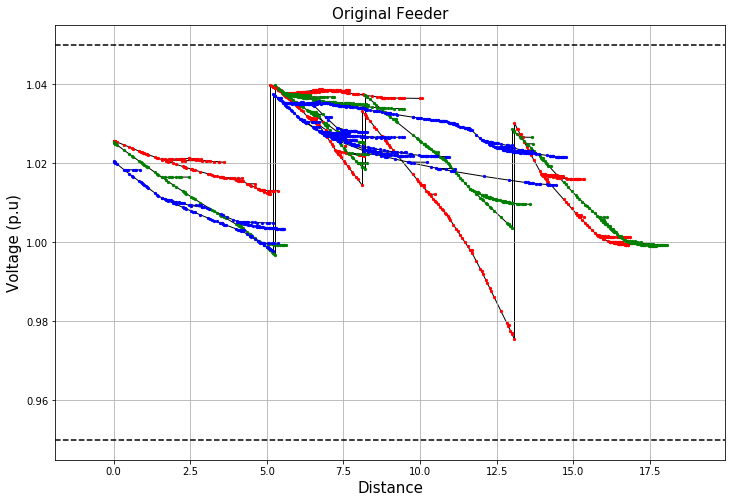

In [42]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.title('Original Feeder', fontsize=15)
#plt.savefig('./J1_origin/voltage_profile_origin.png')

In [43]:
!rm ./EPRI_J1_transformed/voltages_transformed.csv

In [44]:
redirect_transformed_master_file(feeder)
static_stats()

------------------------
N Capacitors = 5
N CapControls = 3
N Lines = 2625
N Loads = 1385
N RegControls = 9
N Transformers = 828
N Buses = 3440
------------------------


In [45]:
dss.dss_lib.DSSPut_Command('Export voltages ./EPRI_J1_transformed/voltages_transformed.csv')
voltages_transformed=pd.read_csv('./EPRI_J1_transformed/voltages_transformed.csv')
voltages_transformed

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,S,69.000,1,38487.500,-2.1,0.96612,2,38495.90,-122.1,0.96633,3,38437.20,117.8,0.96486
1,X_B24288-C,0.416,3,243.395,106.6,1.01340,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
2,X_B24288_CUST7-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
3,X_B24288_CUST6-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
4,X_B24288_CUST5-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
5,X_B42005-A,0.416,1,243.522,-8.6,1.01390,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
6,X_B42005_CUST1-A,0.416,1,242.654,-8.5,1.01030,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
7,X_B24288_CUST3-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
8,X_B24288_CUST2-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000
9,X_B24288_CUST1-C,0.416,3,243.302,106.6,1.01300,0,0.00,0.0,0.00000,0,0.00,0.0,0.00000


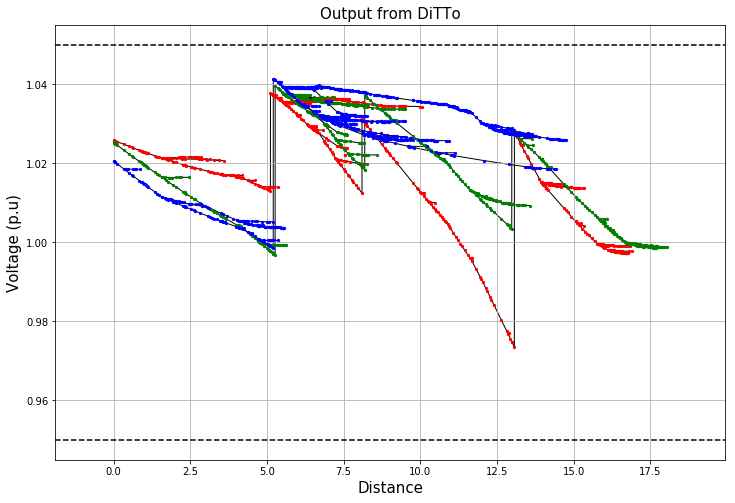

In [46]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.title('Output from DiTTo', fontsize=15)
#plt.savefig('./J1_transformed/voltage_profile_transformed.png')

/Users/ngensoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


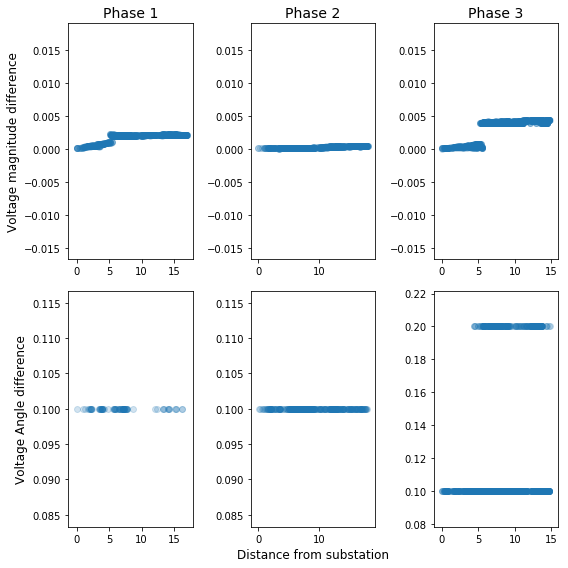

In [47]:
_compare_data=compare_data(voltages_origin, voltages_transformed)

diff_mag=[[],[],[]]
diff_ang=[[],[],[]]
dista=[]

for bus,data in _compare_data.iteritems():
    
    if data['distance'] is not None:
        dista.append(data['distance'])
    else:
        raise ValueError('Distance not Valid')
    for p in range(1,4):
        diff_mag[p-1].append( np.abs( data['origin']['phase {}'.format(p)]['magnitude'] -
                                      data['transformed']['phase {}'.format(p)]['magnitude'] ))
        diff_ang[p-1].append( np.abs( data['origin']['phase {}'.format(p)]['angle'] -
                                      data['transformed']['phase {}'.format(p)]['angle'] ))

diff_mag=map(np.array,diff_mag)
diff_ang=map(np.array,diff_ang)
dista=np.array(dista)

plot_differences(diff_mag, diff_ang, dista)

In [48]:
compare=compare_voltages_pu(voltages_origin, voltages_transformed)
compare_a=compare_angles(voltages_origin, voltages_transformed)
print compare[:10,:]
print compare_a[:10,:]

[[ 0.96633  0.96633]
 [ 1.0259   1.0258 ]
 [ 1.0258   1.0257 ]
 [ 1.0149   1.017  ]
 [ 1.0147   1.0168 ]
 [ 1.0091   1.0095 ]
 [ 1.0087   1.0091 ]
 [ 1.0364   1.0384 ]
 [ 1.0317   1.0277 ]
 [ 1.0043   1.004  ]]
[[ 117.8  117.8]
 [ 112.4  112.4]
 [ 112.4  112.4]
 [   0.     0. ]
 [   0.     0. ]
 [   0.     0. ]
 [   0.     0. ]
 [ 106.6  106.7]
 [ 106.6  106.7]
 [ 110.6  110.7]]


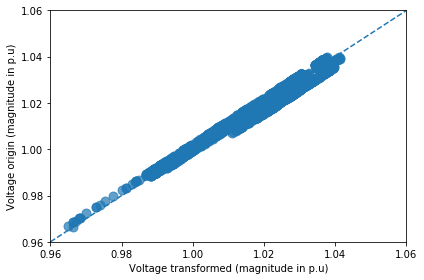

In [49]:
x_min=.96; x_max=1.06
y_min=.96; y_max=1.06
X=np.linspace(x_min,x_max,1000)
plt.scatter(compare[:,0],compare[:,1], s=80, alpha=.7)
plt.plot(X,X,'--')
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.xlabel('Voltage transformed (magnitude in p.u)')
plt.ylabel('Voltage origin (magnitude in p.u)')
plt.tight_layout()
#plt.savefig('./J1_voltages_scatter(Cheating).png')

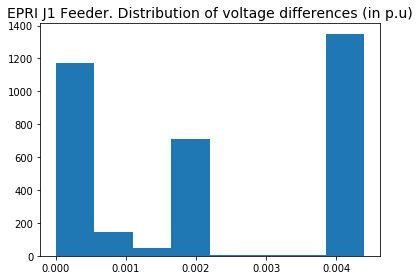

In [50]:
plt.hist(np.abs(compare[:,0]-compare[:,1]), bins=8)
plt.title(r'EPRI J1 Feeder. Distribution of voltage differences (in p.u)', fontsize=14)
plt.tight_layout()
#plt.savefig('./J1_voltages_hist.png')

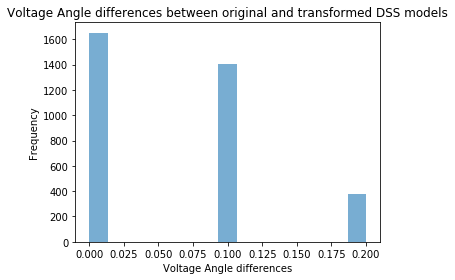

In [51]:
plt.hist(np.abs(compare_a[:,0]-compare_a[:,1]), bins=15, alpha=.6)
plt.title('Voltage Angle differences between original and transformed DSS models')
plt.xlabel('Voltage Angle differences')
plt.ylabel('Frequency')
plt.tight_layout()

# --------- Demo 2 V25 Feeder ---------

In [72]:
feeder=4

In [53]:
m=Store()
reader=Reader()
reader.build_opendssdirect(get_master_file(feeder))
reader.set_dss_file_names({'Nodes':get_bus_file(feeder)})
reader.parse(m, verbose=True)

Parsing the nodes...
Succesful!
Parsing the transformers...
Succesful!
Parsing the loads...
Succesful!
Parsing the lines...


2017-10-16 16:55:23,069 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-16 16:55:23,069 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-16 16:55:23,069 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-16 16:55:23,069 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-16 16:57:49,056 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv1855->cmv944)__70804. Bus1=cmv1855.1. Bus2=cmv1855->cmv944_s.1.2
2017-10-16 16:57:49,056 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionado

2017-10-16 17:08:49,609 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt1993->nssee2_12.47)__70686. Bus1=nssee2_1247.2. Bus2=ncctt1993->nssee2_1247_s.1.2
2017-10-16 17:08:49,609 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt1993->nssee2_12.47)__70686. Bus1=nssee2_1247.2. Bus2=ncctt1993->nssee2_1247_s.1.2
2017-10-16 17:08:49,609 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt1993->nssee2_12.47)__70686. Bus1=nssee2_1247.2. Bus2=ncctt1993->nssee2_1247_s.1.2
2017-10-16 17:08:49,609 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt1993->nssee2_12.47)__70686. Bus1=nssee2_1247.2. Bus2=ncctt1993->nssee2_1247_s.1.2
2017-10-16 17:09:25,937 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():ncctt2663->ncctt911)__70789. Bus1=ncctt911.3. Bus2=ncctt2663->ncctt911_s.1.2
2017-10-16 17:09:25,937 -

2017-10-17 08:51:58,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt5944->nssee3_12.47)__70694. Bus1=nssee3_1247.2. Bus2=ncctt5944->nssee3_1247_s.1.2
2017-10-17 08:51:58,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt5944->nssee3_12.47)__70694. Bus1=nssee3_1247.2. Bus2=ncctt5944->nssee3_1247_s.1.2
2017-10-17 08:51:58,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt5944->nssee3_12.47)__70694. Bus1=nssee3_1247.2. Bus2=ncctt5944->nssee3_1247_s.1.2
2017-10-17 08:51:58,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt5944->nssee3_12.47)__70694. Bus1=nssee3_1247.2. Bus2=ncctt5944->nssee3_1247_s.1.2
2017-10-17 08:52:05,926 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt940->nssee1_12.47)__70675. Bus1=nssee1_1247.3. Bus2=ncctt940->nssee1_1247_s.1.2
2017-10-17 08:52:

Succesful!
Parsing the regulators...
Succesful!
Parsing the capacitors...
Succesful!
Parsing done.


1

In [54]:
writer=Writer(linecodes_flag=True, output_path=get_output_path(feeder))
writer.write(m, write_taps=True, verbose=True)

Writing the bus coordinates...
Succesful!
Writing the transformers...
Succesful!
Writing the regulators...
Succesful!
Writing the capacitors...
Succesful!
Writing the loads...
Succesful!
Writting the linecodes...
Succesful!
Writting the WireData...
Succesful!
Writting the linegeometries...
Succesful!
Writting the lines...
Succesful!
Writting done.


1

In [73]:
dss.dss_lib.DSSPut_Command('redirect {path}'.format(path=get_master_file(feeder)))
dss.dss_lib.DSSPut_Command('Export voltages ./Demo2_v25_origin/voltages_origin.csv')
voltages_origin=pd.read_csv('./Demo2_v25_origin/voltages_origin.csv')
voltages_origin.head()

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,ST_MAT,400.000,1,249406.000,0.0,1.0800,2,249423.000,-120.0,1.0800,3,249416.0,120.0,1.08
1,NCCTT209_BT,0.208,1,129.342,-4.3,1.0771,2,129.352,175.7,1.0771,0,0.0,0.0,0.00
2,CLV27395,0.208,1,129.166,-4.3,1.0756,2,129.176,175.7,1.0757,0,0.0,0.0,0.00
3,CLV27349,0.208,1,128.720,-4.2,1.0719,2,128.730,175.8,1.0720,0,0.0,0.0,0.00
4,CLV27378,0.208,1,129.164,-4.3,1.0756,2,129.174,175.7,1.0757,0,0.0,0.0,0.00


In [74]:
static_stats()

------------------------
N Capacitors = 68
N CapControls = 0
N Lines = 44488
N Loads = 38589
N RegControls = 0
N Transformers = 6494
N Buses = 50943
------------------------


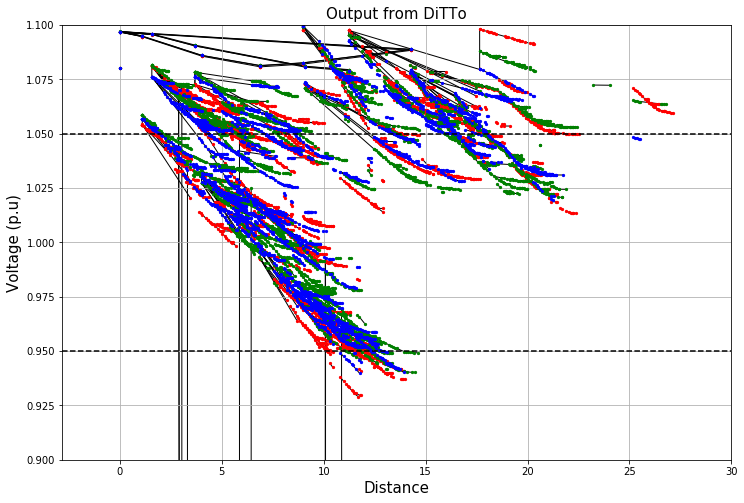

In [75]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.ylim((.9,1.1))
plt.title('Output from DiTTo', fontsize=15)
#plt.savefig('./J1_transformed/voltage_profile_transformed.png')

In [76]:
redirect_transformed_master_file(feeder)
static_stats()

------------------------
N Capacitors = 68
N CapControls = 0
N Lines = 44488
N Loads = 38589
N RegControls = 0
N Transformers = 6494
N Buses = 50943
------------------------


In [77]:
dss.dss_lib.DSSPut_Command('Export voltages ./Demo2_v25_transformed/voltages_transformed.csv')
voltages_transformed=pd.read_csv('./Demo2_v25_transformed/voltages_transformed.csv')
voltages_transformed

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,ST_MAT,400.000,1,245943.000,0.0,1.06500,2,245959.000,-120.0,1.06500,3,245951.00,120.0,1.0650
1,NCCTT2766_BT,0.208,1,126.234,116.9,1.05120,2,126.278,-63.1,1.05150,0,0.00,0.0,0.0000
2,CLV23325,0.208,1,126.141,116.9,1.05040,2,126.185,-63.1,1.05080,0,0.00,0.0,0.0000
3,NCCTT2702_BT,0.208,1,118.897,-124.1,0.99008,2,118.938,56.0,0.99042,0,0.00,0.0,0.0000
4,CLV12959,0.208,1,118.638,-124.0,0.98792,2,118.679,56.0,0.98826,0,0.00,0.0,0.0000
5,NCCTT5708_BT,0.208,1,114.741,-4.4,0.95547,2,114.787,175.6,0.95585,0,0.00,0.0,0.0000
6,CLV11628,0.208,1,114.067,-4.4,0.94986,2,114.113,175.7,0.95024,0,0.00,0.0,0.0000
7,NCCTT973_BT,0.208,1,119.015,-123.9,0.99106,2,119.063,56.2,0.99145,0,0.00,0.0,0.0000
8,CLV12905,0.208,1,118.593,-123.8,0.98754,2,118.640,56.2,0.98793,0,0.00,0.0,0.0000
9,NCCTT359_BT,0.208,1,119.432,-124.9,0.99453,2,119.490,55.2,0.99502,0,0.00,0.0,0.0000


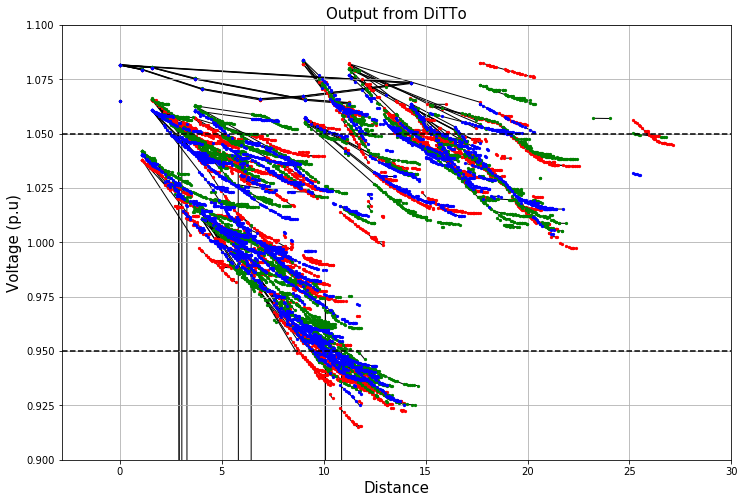

In [78]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.ylim((.9,1.1))
plt.title('Output from DiTTo', fontsize=15)
#plt.savefig('./J1_transformed/voltage_profile_transformed.png')

In [79]:
compare=compare_voltages_pu(voltages_origin, voltages_transformed)
compare

/Users/ngensoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([[ 1.065  ,  1.08   ],
       [ 1.0628 ,  1.0771 ],
       [ 1.0614 ,  1.0757 ],
       ..., 
       [ 1.0827 ,  1.098  ],
       [ 0.96778,  0.98377],
       [ 1.0511 ,  1.0665 ]])

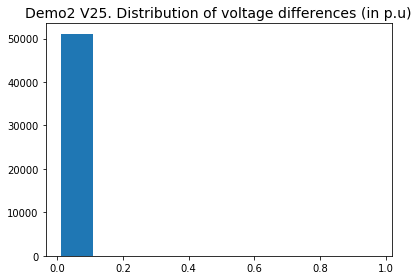

In [80]:
plt.hist(np.abs(compare[:,0]-compare[:,1])/np.max(compare,axis=1), bins=10)
plt.title(r'Demo2 V25. Distribution of voltage differences (in p.u)', fontsize=14)
plt.tight_layout()
#plt.savefig('./Demo2_v25_hist.png')

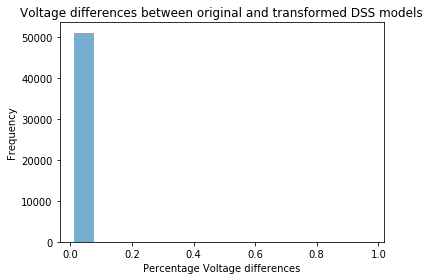

In [81]:
plt.hist(np.abs(compare[:,0]-compare[:,1])/np.max(compare,axis=1), bins=15, alpha=.6)
plt.title('Voltage differences between original and transformed DSS models')
plt.xlabel('Percentage Voltage differences')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('./Demo2_v25_hist.png')

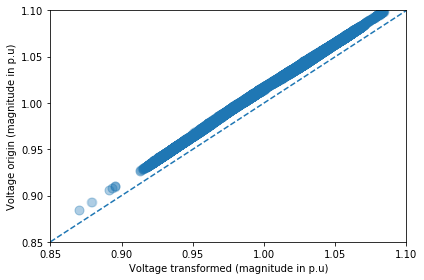

In [82]:
x_min=.85; x_max=1.1
y_min=.85; y_max=1.1
X=np.linspace(x_min,x_max,1000)
plt.scatter(compare[:,0],compare[:,1], s=80, alpha=.2)
plt.plot(X,X,'--')
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.xlabel('Voltage transformed (magnitude in p.u)')
plt.ylabel('Voltage origin (magnitude in p.u)')
plt.tight_layout()
#plt.savefig('./J1_voltages_scatter(Cheating).png')

# --------- Demo 2+ Feeder ---------

In [83]:
feeder=5

In [84]:
m=Store()
reader=Reader()
reader.build_opendssdirect(get_master_file(feeder))
reader.set_dss_file_names({'Nodes':get_bus_file(feeder)})
reader.parse(m, verbose=True)

Parsing the nodes...
Succesful!
Parsing the transformers...
Succesful!
Parsing the loads...
Succesful!
Parsing the lines...


2017-10-17 09:44:40,358 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-17 09:44:40,358 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-17 09:44:40,358 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-17 09:44:40,358 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-17 09:44:40,358 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv343->ncctt4439)__70801. Bus1=cmv343.3. Bus2=cmv343->ncctt4439_s.1.2
2017-10-17 09:47:16,944 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccion

2017-10-17 09:54:49,814 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():ncctt636->nssee8_12.47)__70727. Bus1=nssee8_1247.3. Bus2=ncctt636->nssee8_1247_s.1.2
2017-10-17 09:57:23,639 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():cmv1278->nssee5_12.47)__70703. Bus1=nssee5_1247.1. Bus2=cmv1278->nssee5_1247_s.1.2
2017-10-17 09:57:23,639 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():cmv1278->nssee5_12.47)__70703. Bus1=nssee5_1247.1. Bus2=cmv1278->nssee5_1247_s.1.2
2017-10-17 09:57:23,639 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():cmv1278->nssee5_12.47)__70703. Bus1=nssee5_1247.1. Bus2=cmv1278->nssee5_1247_s.1.2
2017-10-17 09:57:23,639 - OpenDSS_reader - WARNING - Phases do not match for line Line.cinterruptor(cramaee():cmv1278->nssee5_12.47)__70703. Bus1=nssee5_1247.1. Bus2=cmv1278->nssee5_1247_s.1.2
2017-10-17 09:57:23,639 - OpenDSS

2017-10-17 10:03:24,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv1762->ncctt4291)__70777. Bus1=cmv1762.1. Bus2=cmv1762->ncctt4291_s.1.2
2017-10-17 10:03:24,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv1762->ncctt4291)__70777. Bus1=cmv1762.1. Bus2=cmv1762->ncctt4291_s.1.2
2017-10-17 10:03:24,471 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv1762->ncctt4291)__70777. Bus1=cmv1762.1. Bus2=cmv1762->ncctt4291_s.1.2
2017-10-17 10:04:42,805 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv2114->ncctt3155)__70791. Bus1=ncctt3155.3. Bus2=cmv2114->ncctt3155_s.1.2
2017-10-17 10:04:42,805 - OpenDSS_reader - WARNING - Phases do not match for line Line.cseccionador(cramaee():cmv2114->ncctt3155)__70791. Bus1=ncctt3155.3. Bus2=cmv2114->ncctt3155_s.1.2
2017-10-17 10:04:42,805 - OpenDSS_reader - WARNING - Phases do not match for

Succesful!
Parsing the regulators...
Succesful!
Parsing the capacitors...
Succesful!
Parsing done.


1

In [26]:
writer=Writer(linecodes_flag=True, output_path=get_output_path(feeder))
writer.write(m, write_taps=True, verbose=True)

Writing the bus coordinates...
Succesful!
Writing the transformers...
Succesful!
Writing the regulators...
Succesful!
Writing the capacitors...
Succesful!
Writing the loads...
Succesful!
Writting the linecodes...
Succesful!
Writting the WireData...
Succesful!
Writting the linegeometries...
Succesful!
Writting the lines...
Succesful!
Writting done.


1

In [27]:
dss.dss_lib.DSSPut_Command('redirect {path}'.format(path=get_master_file(feeder)))
dss.dss_lib.DSSPut_Command('Export voltages ./Demo2_plus_origin/voltages_origin.csv')
voltages_origin=pd.read_csv('./Demo2_plus_origin/voltages_origin.csv')
voltages_origin.head()

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,ST_MAT,400.000,1,249406.000,0.0,1.0800,2,249423.000,-120.0,1.0800,3,249416.0,120.0,1.08
1,NCCTT209_BT,0.208,1,129.342,-4.3,1.0771,2,129.352,175.7,1.0771,0,0.0,0.0,0.00
2,CLV27395,0.208,1,129.166,-4.3,1.0756,2,129.176,175.7,1.0757,0,0.0,0.0,0.00
3,CLV27349,0.208,1,128.720,-4.2,1.0719,2,128.730,175.8,1.0720,0,0.0,0.0,0.00
4,CLV27378,0.208,1,129.164,-4.3,1.0756,2,129.174,175.7,1.0757,0,0.0,0.0,0.00


In [28]:
static_stats()

------------------------
N Capacitors = 68
N CapControls = 0
N Lines = 44488
N Loads = 38589
N RegControls = 0
N Transformers = 6494
N Buses = 50943
------------------------


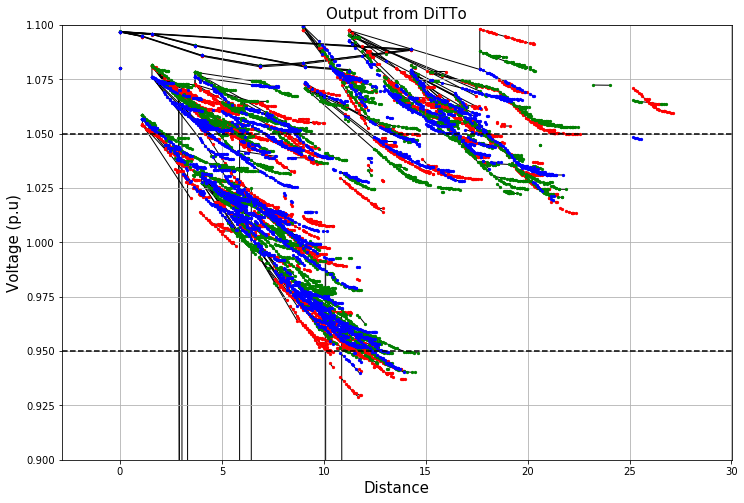

In [166]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
voltage_profile_plot(ax)
plt.ylim((.9,1.1))
plt.title('Output from DiTTo', fontsize=15)
#plt.savefig('./J1_transformed/voltage_profile_transformed.png')

In [29]:
redirect_transformed_master_file(feeder)
static_stats()

------------------------
N Capacitors = 68
N CapControls = 0
N Lines = 44488
N Loads = 38589
N RegControls = 0
N Transformers = 6494
N Buses = 50943
------------------------


In [30]:
!rm ./Demo2_plus_transformed/voltages_transformed.csv

In [31]:
dss.dss_lib.DSSPut_Command('Export voltages ./Demo2_plus_transformed/voltages_transformed.csv')
voltages_transformed=pd.read_csv('./Demo2_plus_transformed/voltages_transformed.csv')
voltages_transformed

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3
0,ST_MAT,400.000,1,249406.000,0.0,1.08000,2,249424.000,-120.0,1.08000,3,249416.00,120.0,1.0800
1,NCCTT2766_BT,0.208,1,128.094,116.9,1.06670,2,128.139,-63.1,1.06700,0,0.00,0.0,0.0000
2,CLV23325,0.208,1,128.000,116.9,1.06590,2,128.044,-63.1,1.06620,0,0.00,0.0,0.0000
3,NCCTT2702_BT,0.208,1,120.868,-124.0,1.00650,2,120.910,56.1,1.00680,0,0.00,0.0,0.0000
4,CLV12959,0.208,1,120.604,-124.0,1.00430,2,120.646,56.1,1.00460,0,0.00,0.0,0.0000
5,NCCTT5708_BT,0.208,1,116.562,-4.4,0.97063,2,116.608,175.7,0.97101,0,0.00,0.0,0.0000
6,CLV11628,0.208,1,115.876,-4.3,0.96492,2,115.922,175.7,0.96531,0,0.00,0.0,0.0000
7,NCCTT973_BT,0.208,1,120.981,-123.8,1.00740,2,121.029,56.2,1.00780,0,0.00,0.0,0.0000
8,CLV12905,0.208,1,120.551,-123.8,1.00380,2,120.599,56.3,1.00420,0,0.00,0.0,0.0000
9,NCCTT359_BT,0.208,1,121.483,-124.8,1.01160,2,121.543,55.2,1.01210,0,0.00,0.0,0.0000


In [32]:
compare=compare_voltages_pu(voltages_origin, voltages_transformed)
#compare_a=compare_angles(voltages_origin, voltages_transformed)
print compare[:10,:]
#print compare_a[:10,:]

[[ 1.08    1.08  ]
 [ 1.0779  1.0771]
 [ 1.0764  1.0757]
 [ 1.0727  1.072 ]
 [ 1.0764  1.0757]
 [ 1.0752  1.0745]
 [ 1.074   1.0732]
 [ 1.0741  1.0733]
 [ 1.0746  1.0738]
 [ 1.0734  1.0726]]


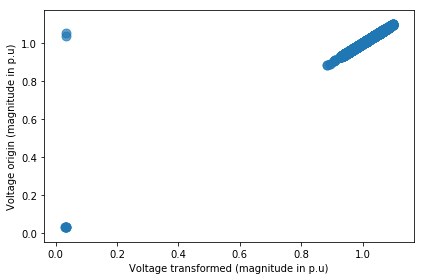

In [33]:
x_min=.96; x_max=1.06
#y_min=.96; y_max=1.06
X=np.linspace(x_min,x_max,1000)
plt.scatter(compare[:,0],compare[:,1], s=80, alpha=.7)
plt.plot(X,X,'--')
#plt.xlim((x_min,x_max))
#plt.ylim((y_min,y_max))
plt.xlabel('Voltage transformed (magnitude in p.u)')
plt.ylabel('Voltage origin (magnitude in p.u)')
plt.tight_layout()
#plt.savefig('./J1_voltages_scatter(Cheating).png')

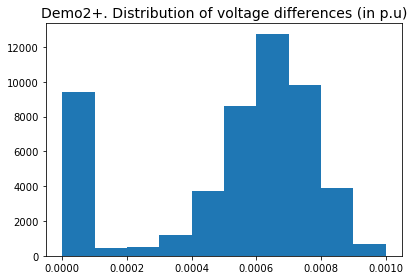

In [34]:
plt.hist(np.sort(np.abs(compare[:,0]-compare[:,1]))[:-2], bins=10)
plt.title(r'Demo2+. Distribution of voltage differences (in p.u)', fontsize=14)
plt.tight_layout()
#plt.savefig('./Demo2_plus_voltages_hist.png')

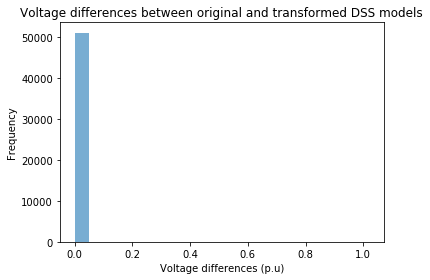

In [23]:
plt.hist(np.abs(compare[:,0]-compare[:,1]), bins=20, alpha=.6)
plt.title('Voltage differences between original and transformed DSS models')
plt.xlabel('Voltage differences (p.u)')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('./J1_voltages_hist.png')

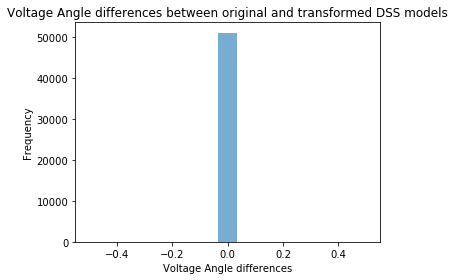

In [22]:
plt.hist(np.abs(compare_a[:,0]-compare_a[:,1]), bins=15, alpha=.6)
plt.title('Voltage Angle differences between original and transformed DSS models')
plt.xlabel('Voltage Angle differences')
plt.ylabel('Frequency')
plt.tight_layout()